In [1]:
import os
import glob
import yaml  # You'll need to install the PyYAML library for YAML parsing
from cloudmesh.common.FlatDict import FlatDict
from pprint import pprint

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np
import humanize

# Define the directory where you want to start the search
start_directory = 'project/'

# Initialize an empty dictionary to store the results
result = []

# Use a recursive search to find all files matching the pattern
for root, dirs, files in os.walk(start_directory):
    for file in files:
        if file.startswith('result') and file.endswith('.out'):
            file_path = os.path.join(root, file)
            with open(file_path, 'r') as f:
                lines = f.readlines()
                csv_lines = [line.strip() for line in lines if line.startswith("# csv")]
                try:
                    result_line = [line.replace(":::MLLOG", "").strip() for line in lines if line.startswith(":::MLLOG") and '"result"' in line][0]
                    result_line = eval(result_line)
                    
                    for k in ['event_type', 'key', 'metadata', 'namespace', 'time_ms']:
                        del result_line[k]
                    
                except:
                    result_line = None
                csv_dict = {}
                for line in csv_lines[1:]:  # Skip the header line
                    line_parts = line.split(',')
                    timer_key = line_parts[1]
                    csv_dict[timer_key] = float(line_parts[3])
            
                if csv_lines:
                    config_path = os.path.join(root, 'config.yaml')
                    config = FlatDict()
                    try:
                        config.loadf(filename=config_path)
                    except:
                        config = None
                    # filter only the "experiment." values

                    filtered = {key.replace("experiment.",""): value 
                                for key, value in dict(config).items() if key.startswith('experiment.')}
                    entry = {
                        'name': file
                    }
                    entry.update(csv_dict)
                    entry.update(filtered)
                    entry.update({"result": result_line})
                    result.append(entry)


# Print the dictionary with the results, including the config
# for filename, data in result_dict.items():
#     print(f'File: {filename}')
#     print('CSV Lines:')
#     for line in data['csv_lines']:
#         print(line)
#    print('Config:')
#    for key, value in data['config'].items():
#        print(f'{key}: {value}')

#pprint(result_dict)

In [2]:
pprint(result[0])

result_data = result.copy()


{'batch_size': 32,
 'card_name': 'v100',
 'clip_offset': 15,
 'cpu_num': 1,
 'directive': 'v100',
 'early_stoppage': 'False',
 'early_stoppage_patience': '25',
 'epoch': '70',
 'gpu': 1,
 'gpu_count': '1',
 'inference': 144.679,
 'learning_rate': 0.001,
 'loaddata': 4.118,
 'mem': '64GB',
 'name': 'result-thf2bn-53854471.out',
 'no_cache': False,
 'nodes': 1,
 'repeat': '5',
 'result': {'value': {'inference': {'accuracy': [0.9233438888888889,
                                                 0.9345094444444444,
                                                 0.8940772222222222,
                                                 0.9105144444444444,
                                                 0.8391288888888889,
                                                 0.95098,
                                                 0.8876861111111111,
                                                 0.7732322222222222,
                                                 0.8472777777777778,
            

In [3]:
df = pd.DataFrame(result)
print(df.columns)

for c in ['epoch', 'repeat']:
    df[c] = df[c].astype(int)
for c in ['total', 'training', 'loaddata', 'inference']:
    df[c] = df[c].astype(float)

df = df.drop(columns=['name', 'mem', 'gpu_count', 'cpu_num', 'seed', 'batch_size', 'clip_offset', 'no_cache', 'gpu', 'nodes', 'train_split', 'learning_rate', 'early_stoppage_patience', 'card_name', 'training_on_mutiple_GPU'])

df['name'] = df['directive'].astype(str) + ',' + df['epoch'].astype(str) + ',' + df['early_stoppage'].astype(str)
df = df[['name'] + [col for col in df.columns if col != 'name']]
df['name'] = df['name'].str.replace(',False', '')
df['name'] = df['name'].str.replace(',True', '.es')
df


Index(['name', 'total', 'training', 'loaddata', 'inference', 'directive',
       'gpu_count', 'cpu_num', 'mem', 'repeat', 'epoch', 'seed',
       'learning_rate', 'batch_size', 'train_split', 'clip_offset', 'no_cache',
       'nodes', 'gpu', 'early_stoppage_patience', 'early_stoppage',
       'card_name', 'result', 'training_on_mutiple_GPU'],
      dtype='object')


name      total   training  loaddata  inference directive  \
0            v100,70  10739.745  10590.600     4.118    144.679      v100   
1            v100,50   7699.156   7554.603     2.069    142.281      v100   
2        v100,200.es  28987.497  28841.568     3.265    142.277      v100   
3      a100-dgx,1.es    535.028    388.821     3.531    142.250  a100-dgx   
4        a100-dgx,50   4778.885   4634.194     2.255    142.229  a100-dgx   
..               ...        ...        ...       ...        ...       ...   
392  a100-dgx,200.es  17123.764  16972.561     4.349    146.636  a100-dgx   
393      v100,200.es  19096.441  18889.292     4.226    202.537      v100   
394    a100-dgx,1.es    834.985    688.298     4.200    142.271  a100-dgx   
395        v100,2.es   1095.535    885.759     4.519    204.995      v100   
396       a100-dgx,1    593.296    448.220     2.499    142.264  a100-dgx   

     repeat  epoch early_stoppage  \
0         5     70          False   
1        10     50          False   
2         4    200           True   
3         1      1           True   
4         9     50          False   
..      ...    ...            ...   
392       7    200           True   
393      15    200           True   
394       2      1           True   
395       3      2           True   
396       8      1          False   

                                                result  
0    {'value': {'name': 'cloudmask', 'training': {'...  
1    {'value': {'name': 'cloudmask', 'training': {'...  
2    {'value': {'name': 'cloudmask', 'training': {'...  
3    {'value': {'name': 'cloudmask', 'training': {'...  
4    {'value': {'name': 'cloudmask', 'training': {'...  
..                                                 ...  
392  {'value': {'name': 'cloudmask', 'training': {'...  
393  {'value': {'name': 'cloudmask', 'training': {'...  
394  {'value': {'name': 'cloudmask', 'training': {'...  
395  {'value': {'name': 'cloudmask', 'training': {'...  
396  {'value': {'name': 'cloudmask', 'training': {'...  

[397 rows x 10 columns]

In [4]:
def exctract(df, newkey='test_accuracy', key1='value', key2='inference', key3='accuracy', key4=None):
    def extract_accuracy(row):
        try:
            if key4 is None:
                return row[key1][key2][key3]
            else:
                return row[key1][key2][key3][key4]
        except KeyError:
            return None
    df[newkey] = df['result'].apply(extract_accuracy)
    return df 

df = exctract(df, 'test_accuracy', 'value', 'inference', 'accuracy')

df = exctract(df, 'training_accuracy', 'value', 'training', 'history', 'accuracy')
df = exctract(df, 'training_loss', 'value', 'training', 'history', 'loss')
df = exctract(df, 'training_val_loss', 'value', 'training', 'history', 'val_loss')
df = exctract(df, 'training_val_accuracy', 'value', 'training', 'history', 'val_accuracy')

df.drop(columns=['result'], inplace=True)

df

name      total   training  loaddata  inference directive  \
0            v100,70  10739.745  10590.600     4.118    144.679      v100   
1            v100,50   7699.156   7554.603     2.069    142.281      v100   
2        v100,200.es  28987.497  28841.568     3.265    142.277      v100   
3      a100-dgx,1.es    535.028    388.821     3.531    142.250  a100-dgx   
4        a100-dgx,50   4778.885   4634.194     2.255    142.229  a100-dgx   
..               ...        ...        ...       ...        ...       ...   
392  a100-dgx,200.es  17123.764  16972.561     4.349    146.636  a100-dgx   
393      v100,200.es  19096.441  18889.292     4.226    202.537      v100   
394    a100-dgx,1.es    834.985    688.298     4.200    142.271  a100-dgx   
395        v100,2.es   1095.535    885.759     4.519    204.995      v100   
396       a100-dgx,1    593.296    448.220     2.499    142.264  a100-dgx   

     repeat  epoch early_stoppage  \
0         5     70          False   
1        10     50          False   
2         4    200           True   
3         1      1           True   
4         9     50          False   
..      ...    ...            ...   
392       7    200           True   
393      15    200           True   
394       2      1           True   
395       3      2           True   
396       8      1          False   

                                         test_accuracy  \
0    [0.9233438888888889, 0.9345094444444444, 0.894...   
1    [0.9291155555555556, 0.9380033333333333, 0.898...   
2    [0.9279722222222222, 0.9363838888888889, 0.900...   
3    [0.8405255555555555, 0.8955255555555556, 0.756...   
4    [0.9231161111111111, 0.9363366666666667, 0.891...   
..                                                 ...   
392  [0.9301033333333333, 0.9350427777777778, 0.895...   
393  [0.9205094444444445, 0.9288383333333333, 0.886...   
394  [0.8741338888888889, 0.9135294444444444, 0.699...   
395  [0.8509655555555555, 0.8973094444444445, 0.677...   
396  [0.8500683333333333, 0.8979433333333333, 0.680...   

                                     training_accuracy  \
0    [0.7971559762954712, 0.8036167621612549, 0.806...   
1    [0.7956450581550598, 0.8075904846191406, 0.809...   
2    [0.7981815338134766, 0.8038926720619202, 0.810...   
3                                 [0.7982280850410461]   
4    [0.7970626354217529, 0.8018134832382202, 0.811...   
..                                                 ...   
392  [0.8012895584106445, 0.8062277436256409, 0.804...   
393  [0.7951487898826599, 0.808780312538147, 0.8055...   
394                               [0.7955150604248047]   
395           [0.7970331311225891, 0.8069105744361877]   
396                               [0.7960869073867798]   

                                         training_loss  \
0    [0.43057680130004883, 0.3868241310119629, 0.37...   
1    [0.43207019567489624, 0.38780638575553894, 0.3...   
2    [0.43074092268943787, 0.38656237721443176, 0.3...   
3                                [0.43050408363342285]   
4    [0.4316985011100769, 0.3839612305164337, 0.379...   
..                                                 ...   
392  [0.4355277419090271, 0.3892213702201843, 0.392...   
393  [0.4343355596065521, 0.3856772780418396, 0.378...   
394                              [0.43002140522003174]   
395          [0.4293251633644104, 0.38269615173339844]   
396                                [0.429758220911026]   

                                     training_val_loss  \
0    [0.45389050245285034, 0.43061962723731995, 0.4...   
1    [0.42624223232269287, 0.41857537627220154, 0.4...   
2    [0.4428444802761078, 0.426952064037323, 0.4229...   
3                                [0.44134214520454407]   
4    [0.43978235125541687, 0.4166964888572693, 0.40...   
..                                                 ...   
392  [0.42452454566955566, 0.42467182874679565, 0.4...   
393  [0.4363936483860016, 0.4224103093147278, 0.416...   
394                              

In [5]:
print (result[0]['result']['value']['inference'].keys())

dict_keys(['avg_accuracy', 'accuracy'])


In [6]:
print(df.head(2).values.tolist())


[['v100,70', 10739.745, 10590.6, 4.118, 144.679, 'v100', 5, 70, 'False', [0.9233438888888889, 0.9345094444444444, 0.8940772222222222, 0.9105144444444444, 0.8391288888888889, 0.95098, 0.8876861111111111, 0.7732322222222222, 0.8472777777777778, 0.9639461111111111, 0.9149733333333333, 0.8905033333333333, 0.6264644444444445, 0.9434594444444444, 0.9502511111111112, 0.8874255555555556, 0.9090383333333333, 0.783135, 0.8810644444444444, 0.8861566666666667, 0.9271861111111112, 0.7000683333333333, 0.9493627777777778, 0.8812888888888889, 0.7280755555555556, 0.9413794444444444, 0.6406661111111112, 0.9485711111111111, 0.8190166666666666, 0.8649538888888889, 0.9245216666666667, 0.5231455555555555, 0.8900266666666666, 0.9201622222222222, 0.8942827777777778, 0.9398694444444444, 0.9456305555555555, 0.8512122222222223, 0.9236327777777777, 0.9262188888888889, 0.8431988888888889, 0.7898244444444444, 0.9462755555555555, 0.9299205555555555, 0.9505644444444444, 0.8782683333333333, 0.8345605555555555, 0.93334

In [7]:
def save_plot_to_multiple_formats(plot, filename_without_extension):
    """
    Save a Matplotlib plot to multiple file formats.

    Args:
        plot (matplotlib.figure.Figure): The Matplotlib figure to save.
        filename_without_extension (str): The base filename without extension.

    Returns:
        None
    """
    # Save as SVG
    svg_filename = filename_without_extension + '.svg'
    plot.savefig(svg_filename, format='svg', bbox_inches='tight')

    # Save as JPG
    jpg_filename = filename_without_extension + '.jpg'
    plot.savefig(jpg_filename, format='jpg', bbox_inches='tight')

    # Save as PNG
    png_filename = filename_without_extension + '.png'
    plot.savefig(png_filename, format='png', bbox_inches='tight')

    # Save as PDF
    pdf_filename = filename_without_extension + '.pdf'
    plot.savefig(pdf_filename, format='pdf', bbox_inches='tight')


In [8]:
df

name      total   training  loaddata  inference directive  \
0            v100,70  10739.745  10590.600     4.118    144.679      v100   
1            v100,50   7699.156   7554.603     2.069    142.281      v100   
2        v100,200.es  28987.497  28841.568     3.265    142.277      v100   
3      a100-dgx,1.es    535.028    388.821     3.531    142.250  a100-dgx   
4        a100-dgx,50   4778.885   4634.194     2.255    142.229  a100-dgx   
..               ...        ...        ...       ...        ...       ...   
392  a100-dgx,200.es  17123.764  16972.561     4.349    146.636  a100-dgx   
393      v100,200.es  19096.441  18889.292     4.226    202.537      v100   
394    a100-dgx,1.es    834.985    688.298     4.200    142.271  a100-dgx   
395        v100,2.es   1095.535    885.759     4.519    204.995      v100   
396       a100-dgx,1    593.296    448.220     2.499    142.264  a100-dgx   

     repeat  epoch early_stoppage  \
0         5     70          False   
1        10     50          False   
2         4    200           True   
3         1      1           True   
4         9     50          False   
..      ...    ...            ...   
392       7    200           True   
393      15    200           True   
394       2      1           True   
395       3      2           True   
396       8      1          False   

                                         test_accuracy  \
0    [0.9233438888888889, 0.9345094444444444, 0.894...   
1    [0.9291155555555556, 0.9380033333333333, 0.898...   
2    [0.9279722222222222, 0.9363838888888889, 0.900...   
3    [0.8405255555555555, 0.8955255555555556, 0.756...   
4    [0.9231161111111111, 0.9363366666666667, 0.891...   
..                                                 ...   
392  [0.9301033333333333, 0.9350427777777778, 0.895...   
393  [0.9205094444444445, 0.9288383333333333, 0.886...   
394  [0.8741338888888889, 0.9135294444444444, 0.699...   
395  [0.8509655555555555, 0.8973094444444445, 0.677...   
396  [0.8500683333333333, 0.8979433333333333, 0.680...   

                                     training_accuracy  \
0    [0.7971559762954712, 0.8036167621612549, 0.806...   
1    [0.7956450581550598, 0.8075904846191406, 0.809...   
2    [0.7981815338134766, 0.8038926720619202, 0.810...   
3                                 [0.7982280850410461]   
4    [0.7970626354217529, 0.8018134832382202, 0.811...   
..                                                 ...   
392  [0.8012895584106445, 0.8062277436256409, 0.804...   
393  [0.7951487898826599, 0.808780312538147, 0.8055...   
394                               [0.7955150604248047]   
395           [0.7970331311225891, 0.8069105744361877]   
396                               [0.7960869073867798]   

                                         training_loss  \
0    [0.43057680130004883, 0.3868241310119629, 0.37...   
1    [0.43207019567489624, 0.38780638575553894, 0.3...   
2    [0.43074092268943787, 0.38656237721443176, 0.3...   
3                                [0.43050408363342285]   
4    [0.4316985011100769, 0.3839612305164337, 0.379...   
..                                                 ...   
392  [0.4355277419090271, 0.3892213702201843, 0.392...   
393  [0.4343355596065521, 0.3856772780418396, 0.378...   
394                              [0.43002140522003174]   
395          [0.4293251633644104, 0.38269615173339844]   
396                                [0.429758220911026]   

                                     training_val_loss  \
0    [0.45389050245285034, 0.43061962723731995, 0.4...   
1    [0.42624223232269287, 0.41857537627220154, 0.4...   
2    [0.4428444802761078, 0.426952064037323, 0.4229...   
3                                [0.44134214520454407]   
4    [0.43978235125541687, 0.4166964888572693, 0.40...   
..                                                 ...   
392  [0.42452454566955566, 0.42467182874679565, 0.4...   
393  [0.4363936483860016, 0.4224103093147278, 0.416...   
394                              

In [9]:

es_false_df = df[df['early_stoppage'] == 'False'].copy()
es_true_df = df[df['early_stoppage'] == 'True'].copy()
df_all = df.copy()


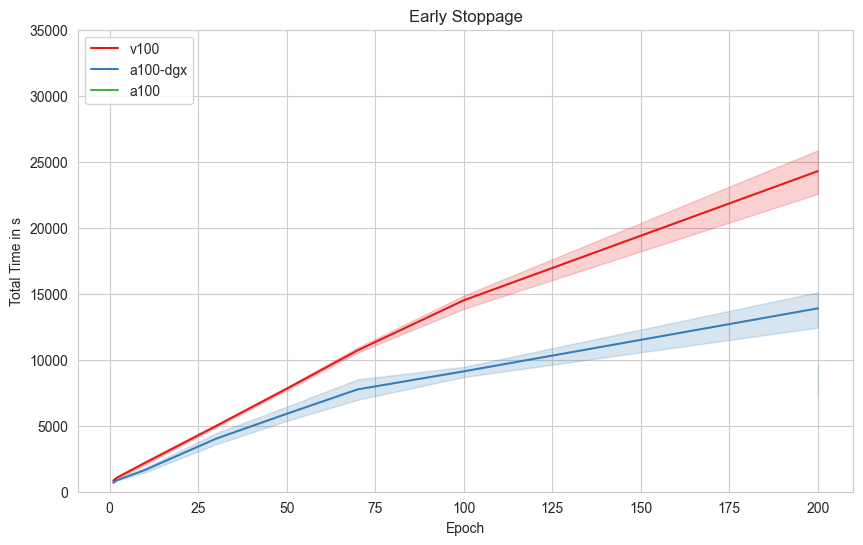

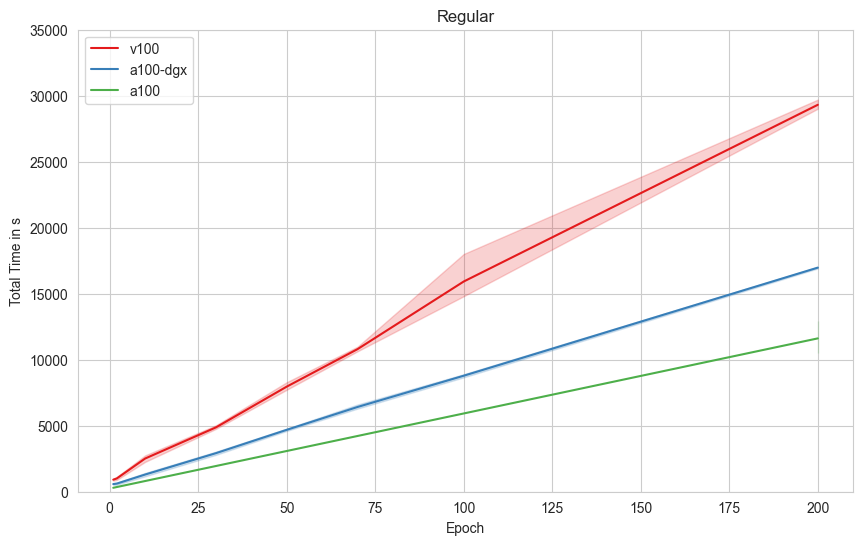

In [10]:

def create_line_plot(df, title):
    plt.figure(figsize=(10, 6))  # Optional: Set the figure size
    plot = sns.lineplot(x='epoch', y='total', hue='directive', data=df, palette='Set1')
    plt.xlabel('Epoch')
    plt.ylabel('Total Time in s')
    legend = plt.legend(title='Directive')
    legend.set_title('GPU')
    plt.ylim(0, 35000)
    plt.title(title)
    plt.legend(loc='upper left')
    plt.show()


create_line_plot(es_true_df, "Early Stoppage")
create_line_plot(es_false_df, "Regular")

100 False


/home/green/ENV3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Derived Formula: directive
t(epoch, v100) = 705.00 + 148.65 * epoch
t(200) = 30434.01 s or 8.45 hours
t(200, hh:mm:ss)= 08:27:14


/home/green/ENV3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Derived Formula: directive
t(epoch, a100-dgx) = 470.51 + 83.76 * epoch
t(200) = 17221.53 s or 4.78 hours
t(200, hh:mm:ss)= 04:47:01


<Figure size 640x480 with 0 Axes>

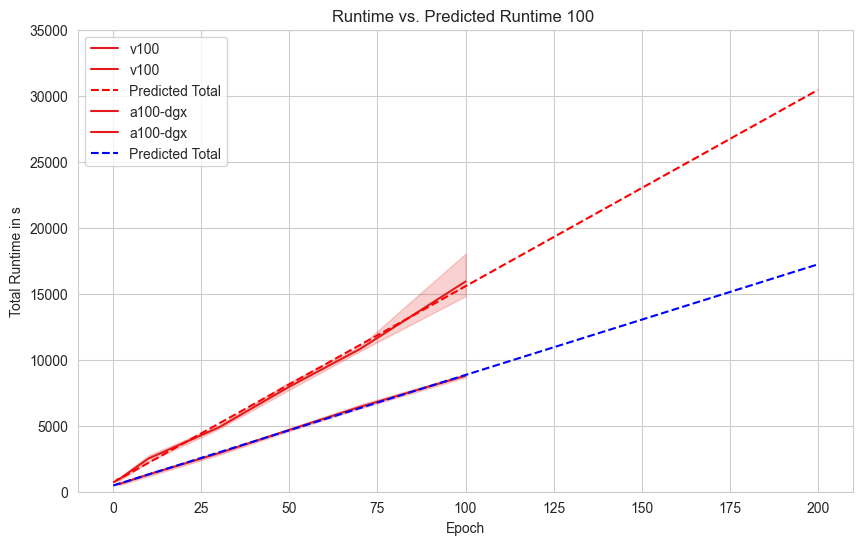

100 True


/home/green/ENV3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Derived Formula: directive, es
t(epoch, v100, es) = 794.41 + 138.80 * epoch
t(200) = 28554.88 s or 7.93 hours
t(200, hh:mm:ss)= 07:55:54


/home/green/ENV3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Derived Formula: directive, es
t(epoch, a100-dgx, es) = 928.49 + 89.37 * epoch
t(200) = 18802.53 s or 5.22 hours
t(200, hh:mm:ss)= 05:13:22


<Figure size 640x480 with 0 Axes>

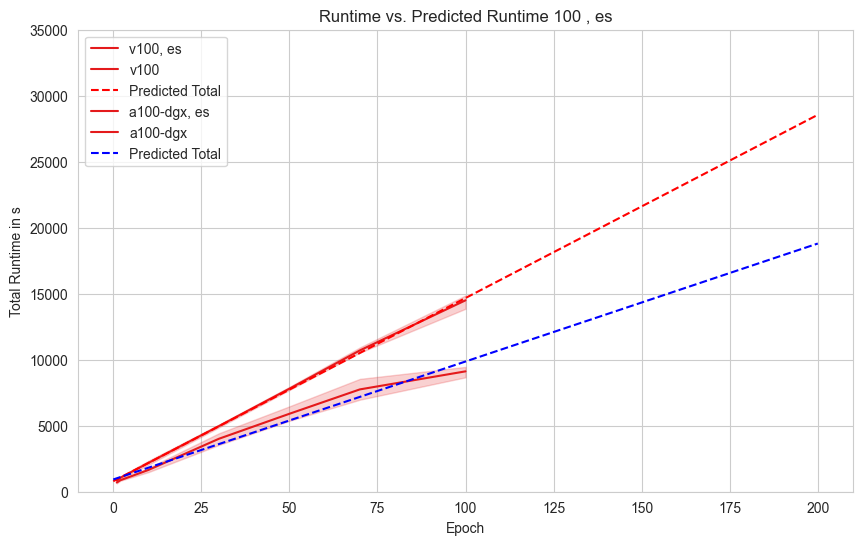

In [11]:
def plot_predicted_runtimes(df, epoch, early_stoppage):
    plt.figure(figsize=(10, 6))
    plt.xlabel('Epoch')
    plt.ylabel('Total Runtime in s')
    
    if early_stoppage == "True":
        es = ", es"
    else:
        es = ""

    color = {
        'v100': 'red',
        'a100-dgx': 'blue'
    }
    
    for directive in ['v100', 'a100-dgx']:
        data = df[(df['directive'] == directive)]

        data = data[['epoch', 'total', 'directive']]
        plot = sns.lineplot(x='epoch', y='total', hue='directive', data=data, palette='Set1', label=f"{directive}{es}")
        
        X = data[['epoch']]
        y = data['total']
        
        model = LinearRegression()
        model.fit(X, y)
        
        epochs_to_predict = np.arange(0, 201).reshape(-1, 1)
        predicted_total = model.predict(epochs_to_predict)
        
        intercept = model.intercept_
        slope = model.coef_[0]
        
        formula = f"t(epoch, {directive}{es}) = {intercept:.2f} + {slope:.2f} * epoch"
        
        
        print(f"Derived Formula: directive{es}")
        print(formula)
        t_epoch = 200
        value = intercept + slope * t_epoch
        value = round(value, 2)
        print(f"t({t_epoch}) = {value} s", "or", humanize.precisedelta(value, minimum_unit='hours'))

        
        hours = int(value // 3600)
        minutes = int((value % 3600) // 60)
        seconds = int(value % 60)
        
        # Format as "hh:mm:ss"
        formatted_time = f"{hours:02d}:{minutes:02d}:{seconds:02d}"
        
        # Print the result
        print(f"t(200, hh:mm:ss)= {formatted_time}")

        plt.plot(epochs_to_predict, predicted_total, marker='', linestyle='--', color=color[directive], label='Predicted Total')

    plt.title(f'Runtime vs. Predicted Runtime {epoch} {es}')
    plt.legend()
    plt.ylim(0, 35000)
    plt.grid(True)
    plt.show()
   

for  target_epoch, target_early_stoppage in [(100, "False"), (100, "True")]:
    plt.clf()
    filtered_df = df[(df['epoch'] <= target_epoch) & (df['early_stoppage'] == target_early_stoppage)]
    print (f"{target_epoch} {target_early_stoppage}")
    plot_predicted_runtimes(filtered_df, target_epoch, target_early_stoppage)

In [12]:
import humanize

epoch = 200
t = 470.51 + 83.76 * epoch
t = humanize.precisedelta(t, minimum_unit='hours')
print("a100", t)


epoch = 200
t = 705.00 + 148.65 * epoch
t = humanize.precisedelta(t, minimum_unit='hours')
print("v100", t)


a100 4.78 hours
v100 8.45 hours


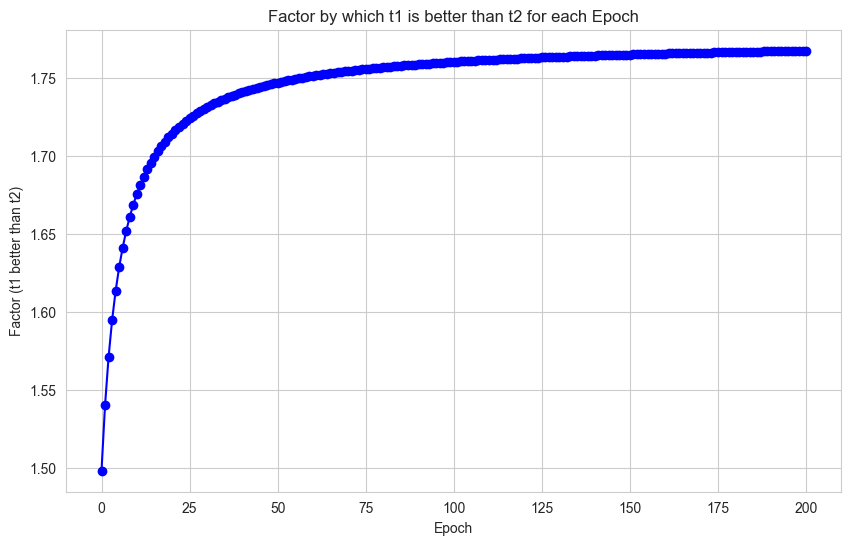

Overall 1.77


In [13]:
epoch_values = np.arange(0, 201)

# Initialize an empty list to store the factors
factors = []

# Calculate the factors for each 'epoch' value
for epoch_value in epoch_values:
    t1_value = 705.00 + 148.65 * epoch_value
    t2_value = 470.51 + 83.76 * epoch_value
    factor = t1_value / t2_value
    factors.append(factor)

# Create a line plot of the factors
plt.figure(figsize=(10, 6))
plt.plot(epoch_values, factors, marker='o', linestyle='-', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Factor (t1 better than t2)')
plt.title('Factor by which t1 is better than t2 for each Epoch')
plt.grid(True)
plt.show()

epoch_value = 200
t1_value = 705.00 + 148.65 * epoch_value
t2_value = 470.51 + 83.76 * epoch_value
factor = t1_value / t2_value
    
print ("Overall", round(factor,2))

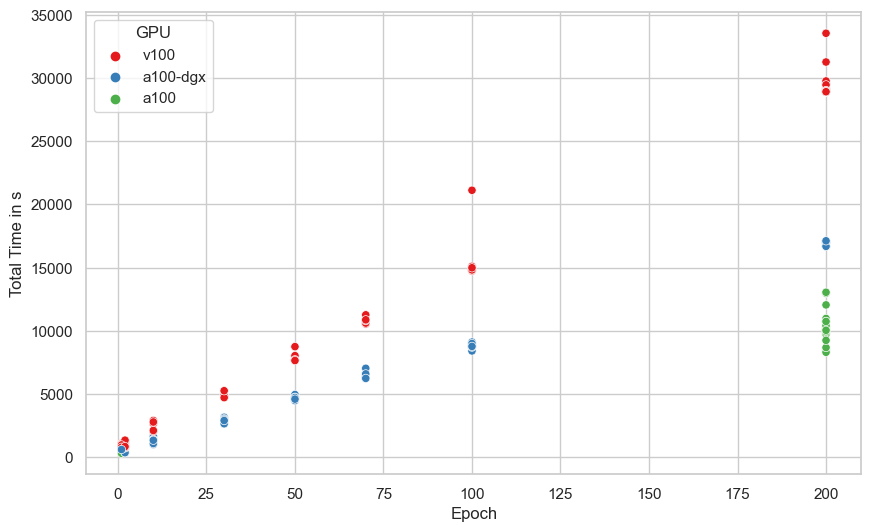

In [14]:
df = es_false_df
# Set the style of the plot
sns.set(style="whitegrid")

# Create a scatter plot using Seaborn
plt.figure(figsize=(10, 6))  # Optional: Set the figure size
sns.scatterplot(x='epoch', y='total', hue='directive', data=df, palette='Set1')

# Add labels and legend
plt.xlabel('Epoch')
plt.ylabel('Total Time in s')
plt.legend(title='GPU')

# Show the plot
plt.show()



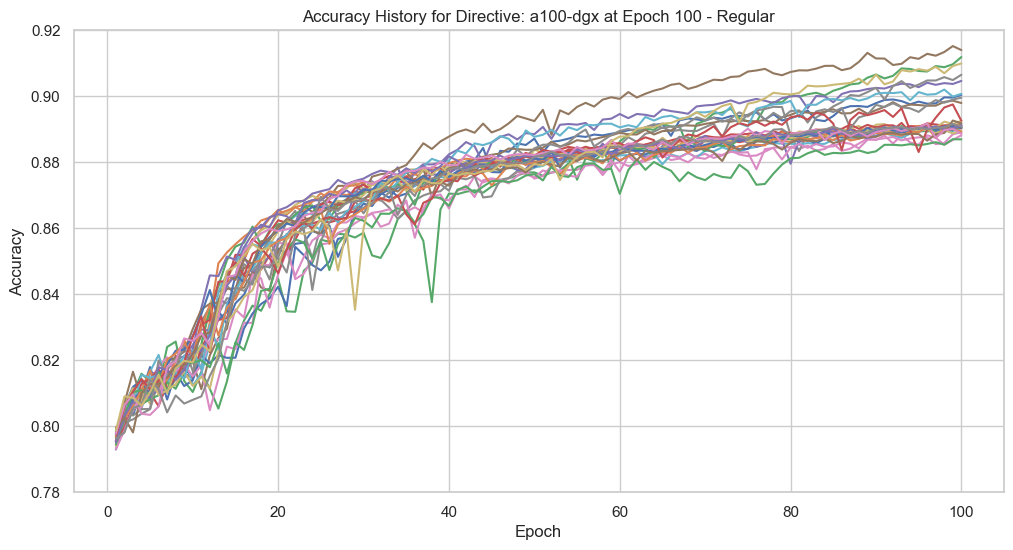

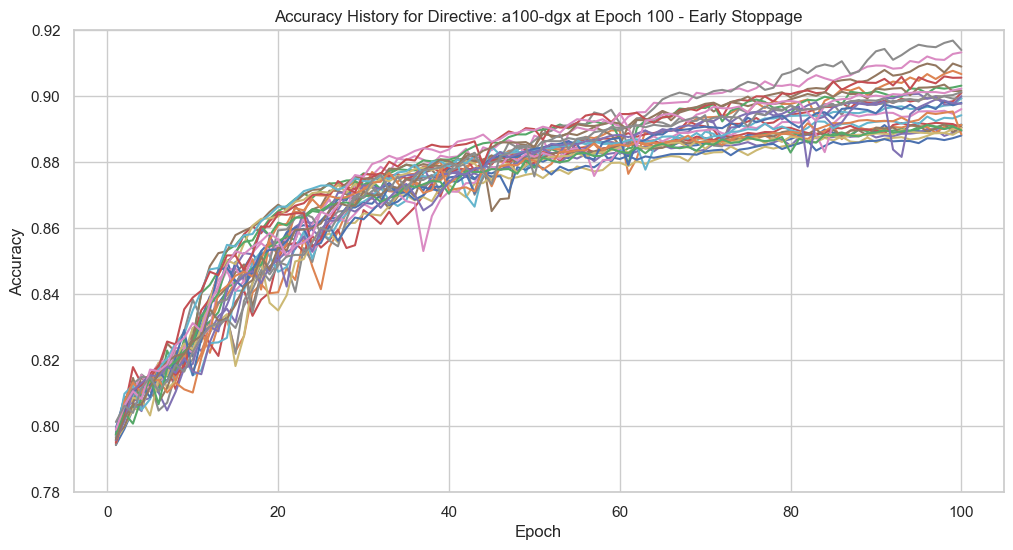

In [15]:
def plot_accuracy_history_for_directive(df, selected_directive, selected_epoch, title):
    # Filter rows with valid directive names
    df = df[df['directive'].notna()]

    # Filter the DataFrame for the selected directive and epoch
    filtered_df = df[(df['directive'] == selected_directive) & (df['training_accuracy'].apply(lambda x: len(x)) >= selected_epoch)]

    # Create an empty list to store accuracy histories
    accuracy_histories = []

    # Iterate through the filtered DataFrame and extract accuracy histories
    for index, row in filtered_df.iterrows():
        accuracy_history = row['training_accuracy']
        accuracy_histories.append(accuracy_history[:selected_epoch])

    # Create a Seaborn line plot for all matching directives
    plt.figure(figsize=(12, 6))
    sns.set_style("whitegrid")

    for idx, accuracy_history in enumerate(accuracy_histories):
        sns.lineplot(x=range(1, selected_epoch + 1), y=accuracy_history)
        # sns.lineplot(x=range(1, selected_epoch + 1), y=accuracy_history, label=f'Result {idx + 1}')

    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy History for Directive: {selected_directive} at Epoch {selected_epoch} - {title}')
    # plt.legend(title='Results')
    plt.ylim(0.78, 0.92)
    plt.show()

selected_directive = 'a100-dgx'  # Replace with your desired directive
selected_epoch = 100

plot_accuracy_history_for_directive(es_false_df, selected_directive, selected_epoch, "Regular")
plot_accuracy_history_for_directive(es_true_df, selected_directive, selected_epoch, "Early Stoppage")

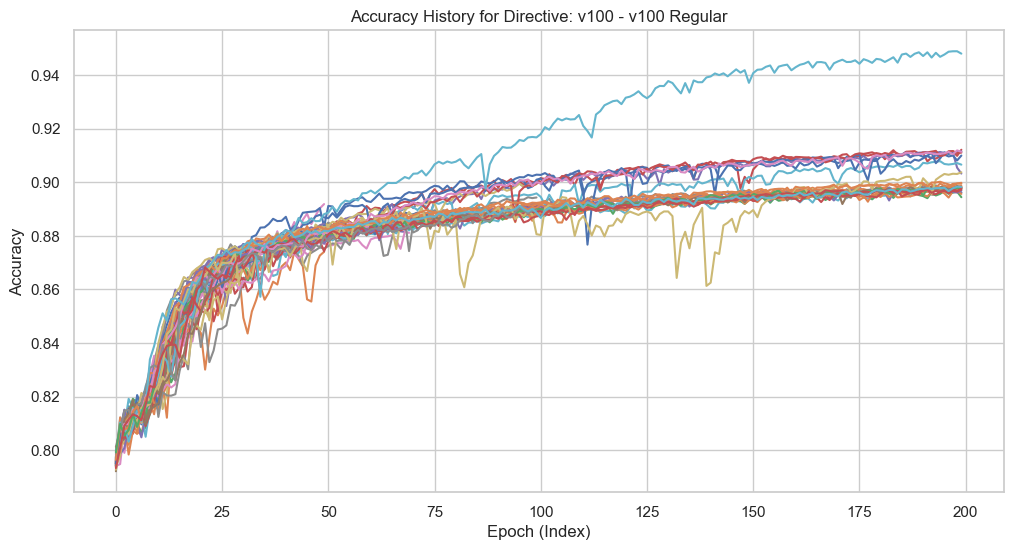

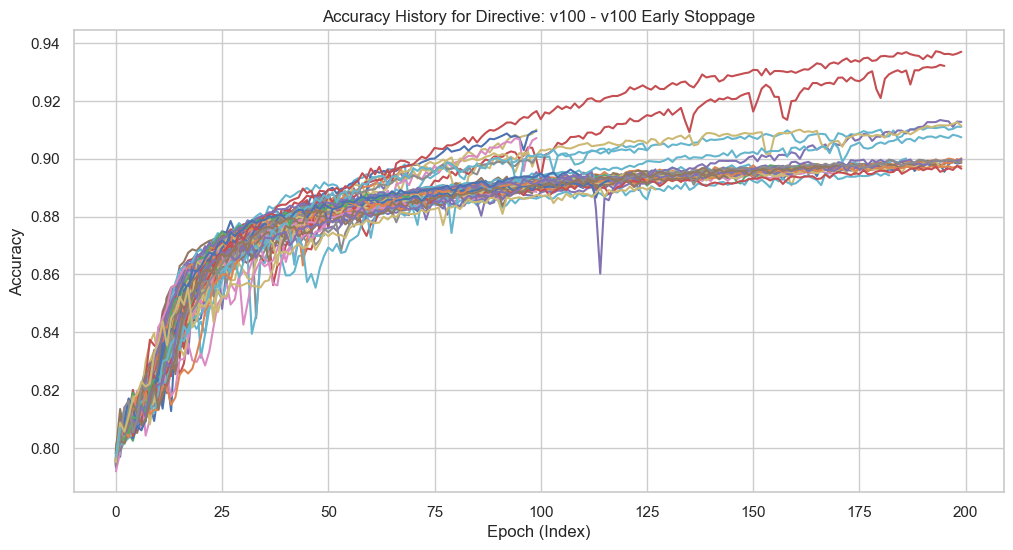

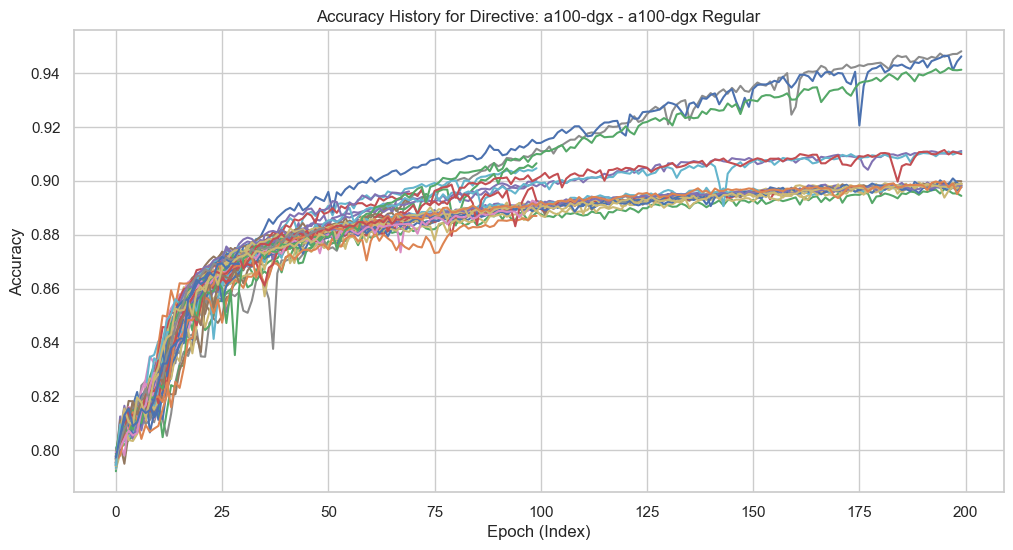

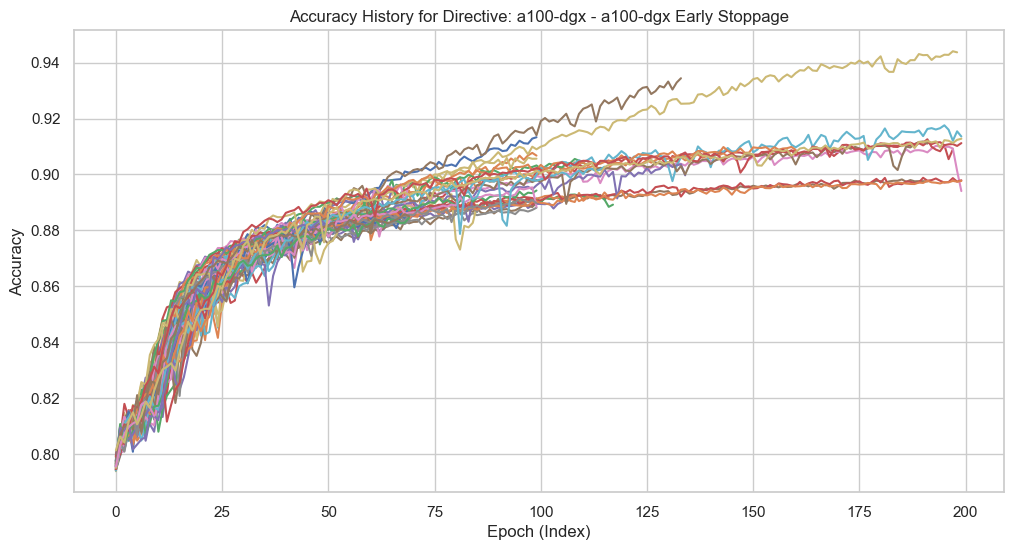

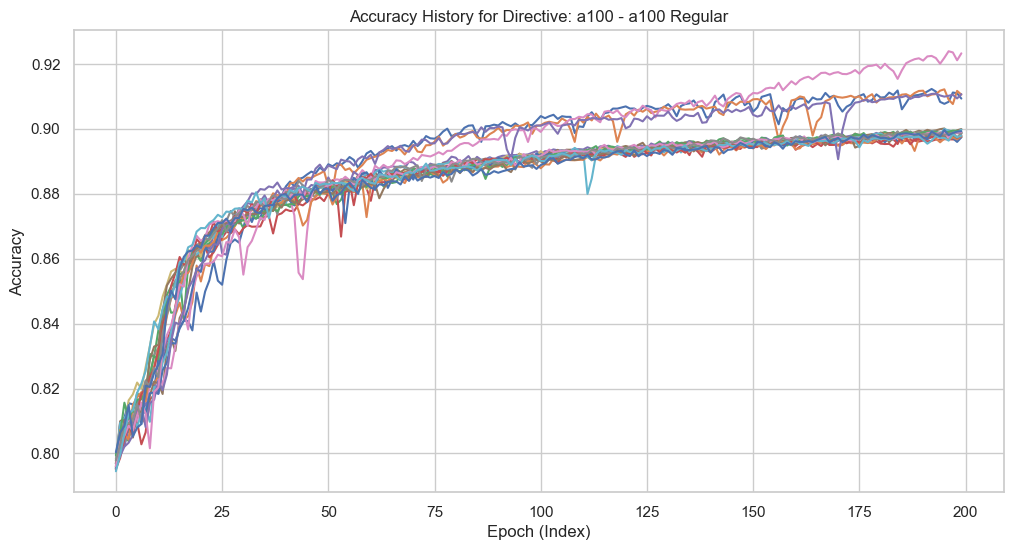

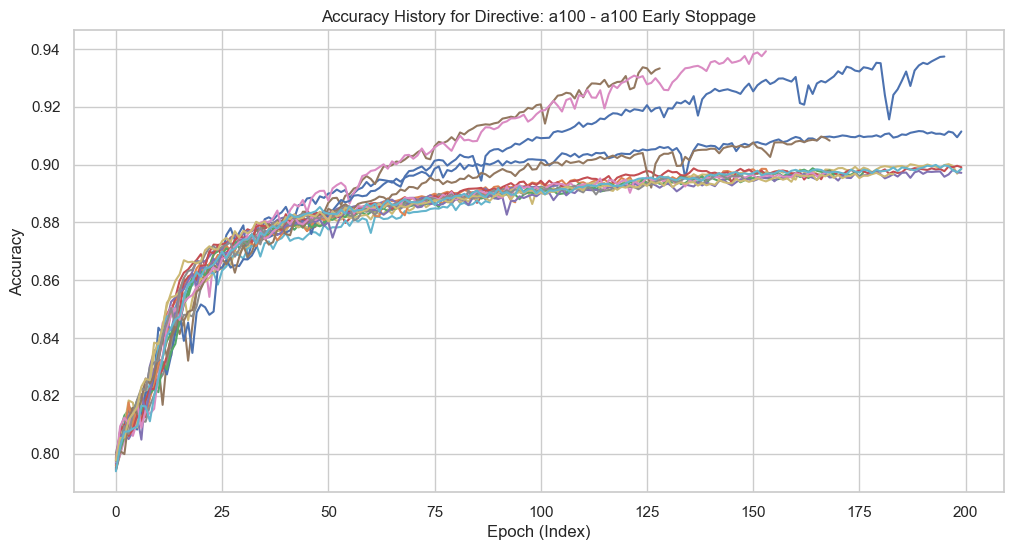

In [16]:


def plot_accuracy_history(df, title, directive):
    # Filter rows with valid directive names
    df = df[df['directive'].notna()]

    # Specify the directive you want to plot
    selected_directive = directive  # Replace with your desired directive

    # Filter the DataFrame for the selected directive
    directive_df = df[df['directive'] == selected_directive]

    # Extract all accuracy histories for the selected directive
    accuracy_histories = directive_df['training_accuracy'].apply(lambda x: x)

    # Create a Seaborn line plot for all accuracy histories
    plt.figure(figsize=(12, 6))
    sns.set(style="whitegrid")

    for idx, accuracy_history in enumerate(accuracy_histories):
        x_values = list(range(len(accuracy_history)))
        # sns.lineplot(x=x_values, y=accuracy_history, label=f'Result {idx + 1}')
        sns.lineplot(x=x_values, y=accuracy_history)

    plt.xlabel('Epoch (Index)')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy History for Directive: {selected_directive} - {directive} {title}')
    # plt.legend(title='Results')
    plt.show()
    
for directive in ["v100", "a100-dgx", "a100"]:
    plot_accuracy_history(es_false_df, "Regular", directive)
    plot_accuracy_history(es_true_df, "Early Stoppage", directive)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


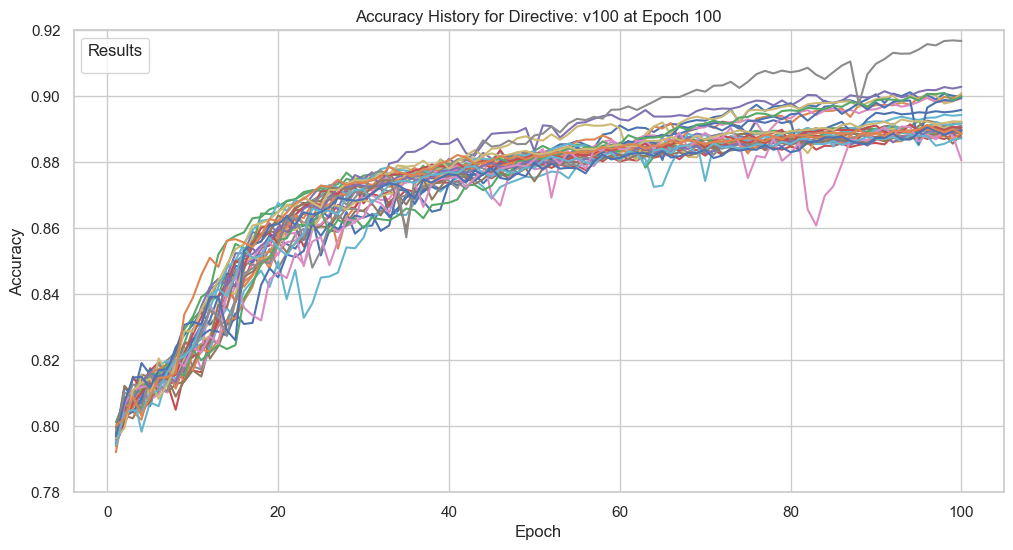

In [17]:


# Filter rows with valid directive names
df = df[df['directive'].notna()]

# Specify the directive you want to select
selected_directive = 'v100'  # Replace with your desired directive
selected_epoch = 100

# Filter the DataFrame for the selected directive and epoch
filtered_df = df[(df['directive'] == selected_directive) & (df['training_accuracy'].apply(lambda x: len(x)) >= selected_epoch)]

# Create an empty list to store accuracy histories
accuracy_histories = []

# Iterate through the filtered DataFrame and extract accuracy histories
for index, row in filtered_df.iterrows():
    accuracy_history = row['training_accuracy']
    accuracy_histories.append(accuracy_history[:selected_epoch])

# Create a Seaborn line plot for all matching directives
plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")

for idx, accuracy_history in enumerate(accuracy_histories):
    # sns.lineplot(x=range(1, selected_epoch + 1), y=accuracy_history, label=f'Result {idx + 1}')
    sns.lineplot(x=range(1, selected_epoch + 1), y=accuracy_history)

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title(f'Accuracy History for Directive: {selected_directive} at Epoch {selected_epoch}')
plt.legend(title='Results')
plt.ylim(0.78, 0.92)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


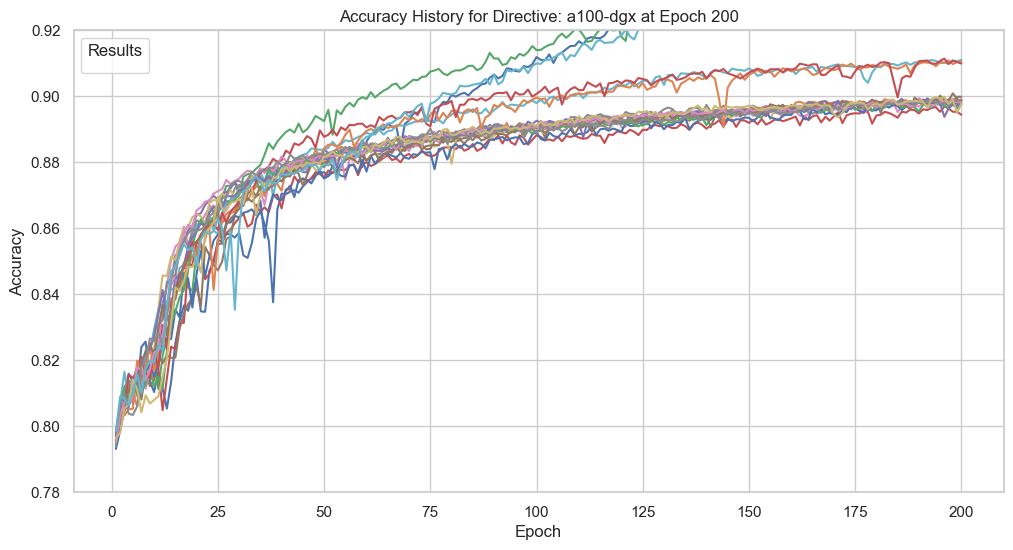

In [18]:
df = df[df['directive'].notna()]

# Specify the directive you want to select
selected_directive = 'a100-dgx'  # Replace with your desired directive
selected_epoch = 200

# Filter the DataFrame for the selected directive and epoch
filtered_df = df[(df['directive'] == selected_directive) & (df['training_accuracy'].apply(lambda x: len(x)) >= selected_epoch)]

# Create an empty list to store accuracy histories
accuracy_histories = []

# Iterate through the filtered DataFrame and extract accuracy histories
for index, row in filtered_df.iterrows():
    accuracy_history = row['training_accuracy']
    accuracy_histories.append(accuracy_history[:selected_epoch])

# Create a Seaborn line plot for all matching directives
plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")

for idx, accuracy_history in enumerate(accuracy_histories):
    # sns.lineplot(x=range(1, selected_epoch + 1), y=accuracy_history, label=f'Result {idx + 1}')
    sns.lineplot(x=range(1, selected_epoch + 1), y=accuracy_history)

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title(f'Accuracy History for Directive: {selected_directive} at Epoch {selected_epoch}')
plt.legend(title='Results')
plt.ylim(0.78, 0.92)
plt.show()

In [19]:
def plot_history(data, epoch=100, directives=["a100-dgx","v100"], value="training_accuracy"):
    df = data[data['directive'].notna()].copy()
    
    # Specify the list of directives you want to select
    selected_directives = directives # ['a100-dgx', 'v100']  # Replace with your desired directives
    selected_epoch = epoch
    
    # Create an empty list to store accuracy histories for each directive
    accuracy_histories_dict = {directive: [] for directive in selected_directives}
    
    
    
    # Iterate through the DataFrame and extract accuracy histories for selected directives
    for directive in selected_directives:
        filtered_df = df[(df['directive'] == directive) & (df[value].apply(lambda x: len(x)) >= selected_epoch)]
        
        for index, row in filtered_df.iterrows():
            accuracy_history = row[value]
            accuracy_histories_dict[directive].append(accuracy_history[:selected_epoch])
    
    # Create Seaborn line plots for each directive with a legend
    plt.figure(figsize=(12, 6))
    sns.set(style="whitegrid")
    
    for directive, accuracy_histories in accuracy_histories_dict.items():
        for idx, accuracy_history in enumerate(accuracy_histories):
            #sns.lineplot(x=range(1, selected_epoch + 1), y=accuracy_history, label=f'{directive} - Result {idx + 1}')
            sns.lineplot(x=range(1, selected_epoch + 1), y=accuracy_history)
    
    plt.xlabel('Epoch')
    # plt.ylabel(value.capitalize())
    plt.ylabel(value.capitalize().replace("_", " ").replace('val', "validation"))
    plt.title(f'Accuracy History for Directives at Epoch {selected_epoch}')
    plt.legend()
    #plt.ylim(0.78, 0.92)
    plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


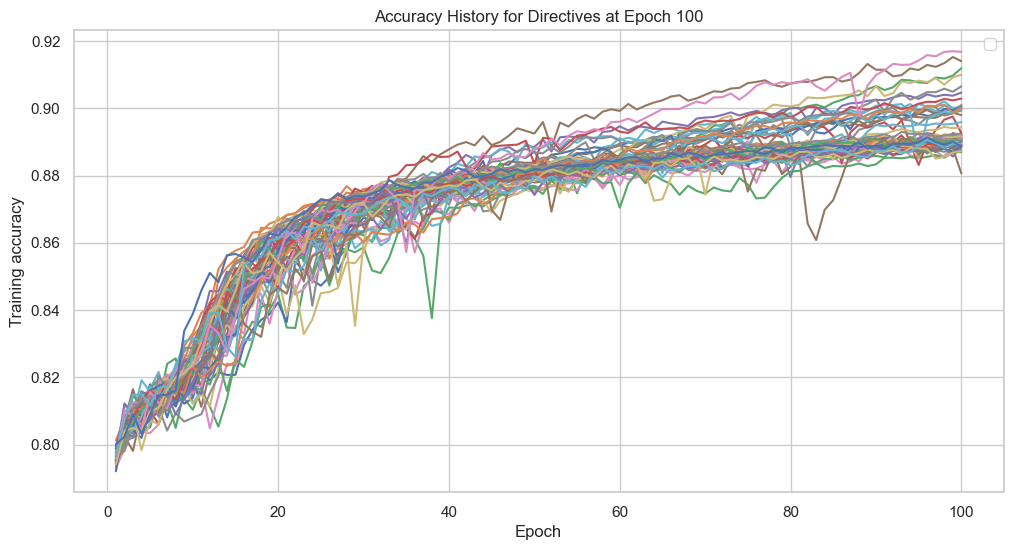

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


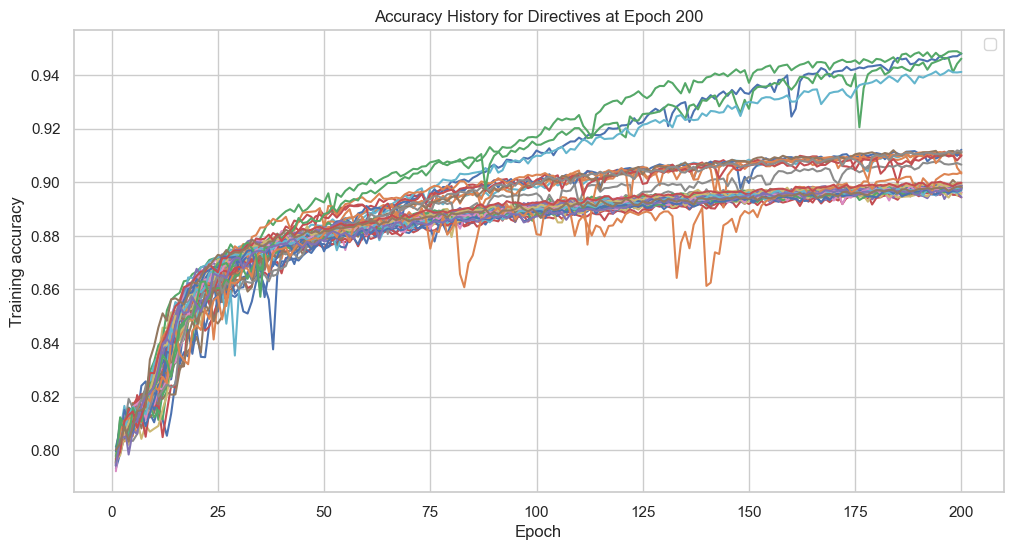

In [20]:


value = 'accuracy'
# Filter rows with valid directive names
df = df[df['directive'].notna()]

for epoch in [100,200]:
    plot_history(df, directives=['a100-dgx', 'v100'], epoch=epoch, value="training_accuracy")



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


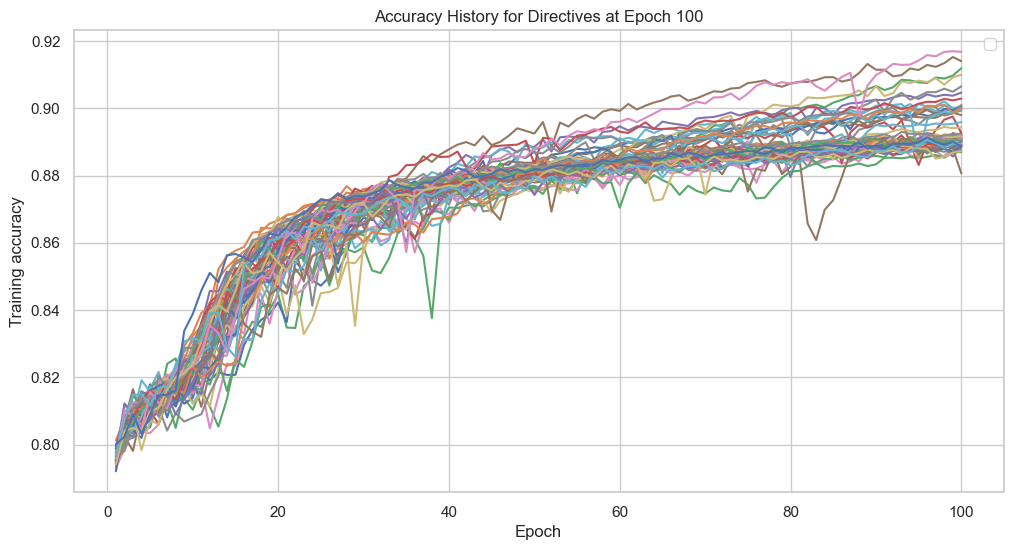

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


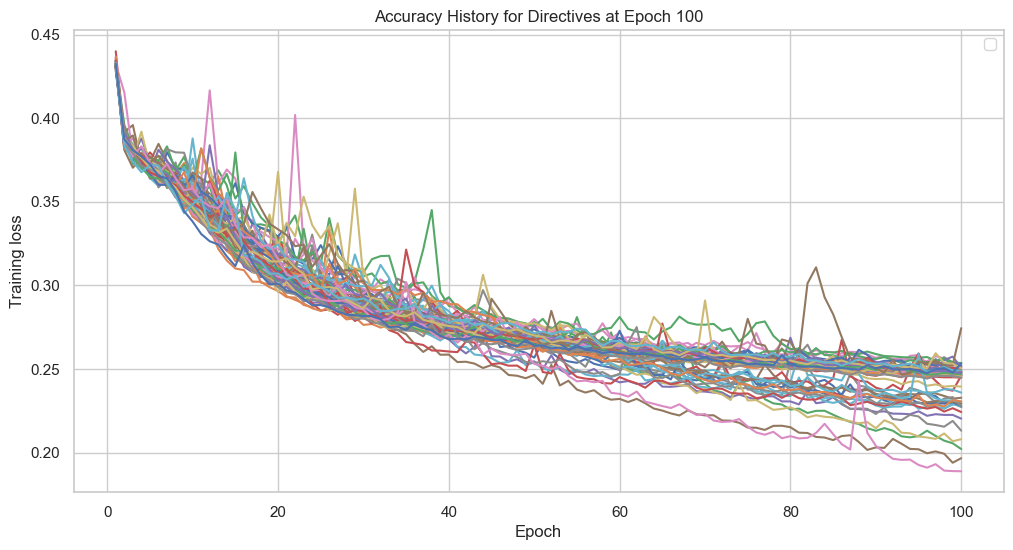

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


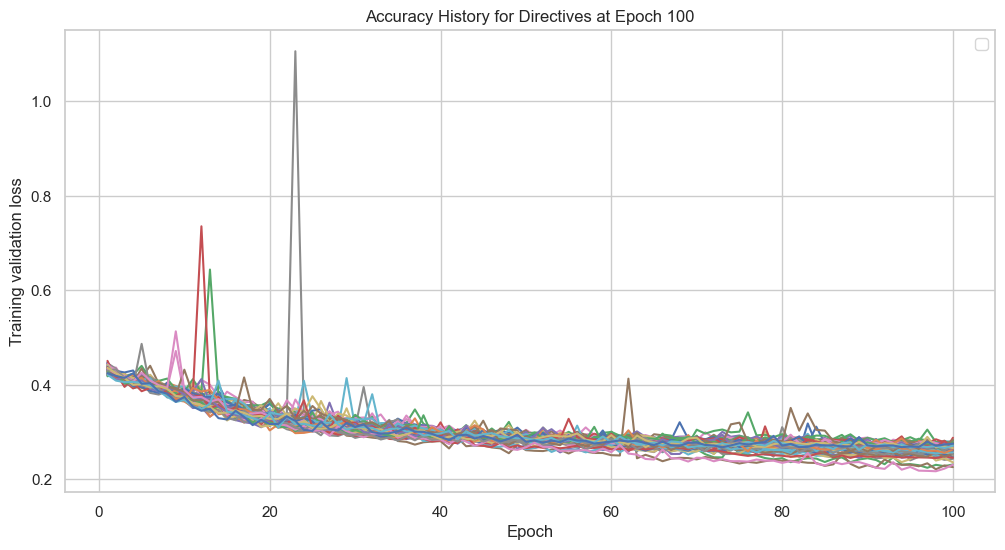

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


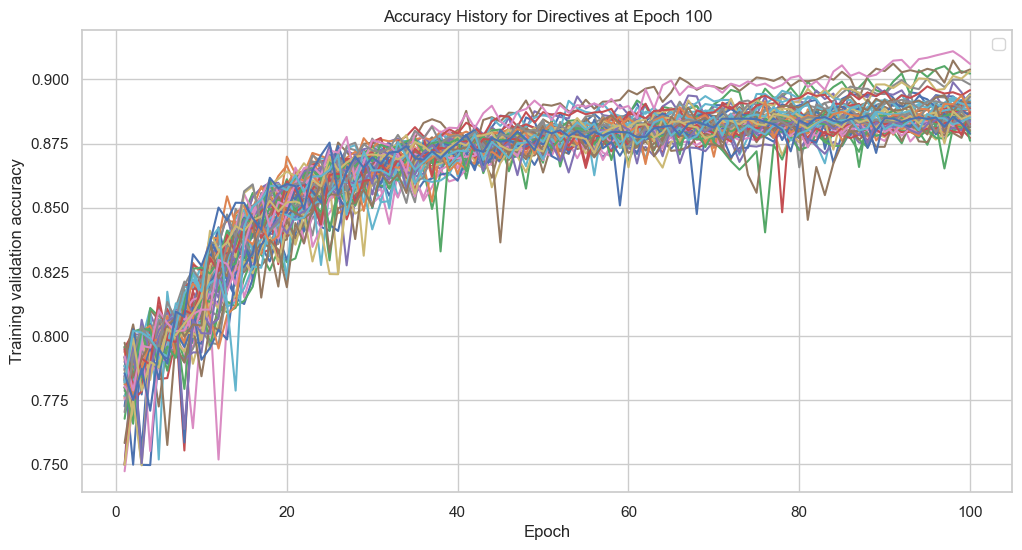

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


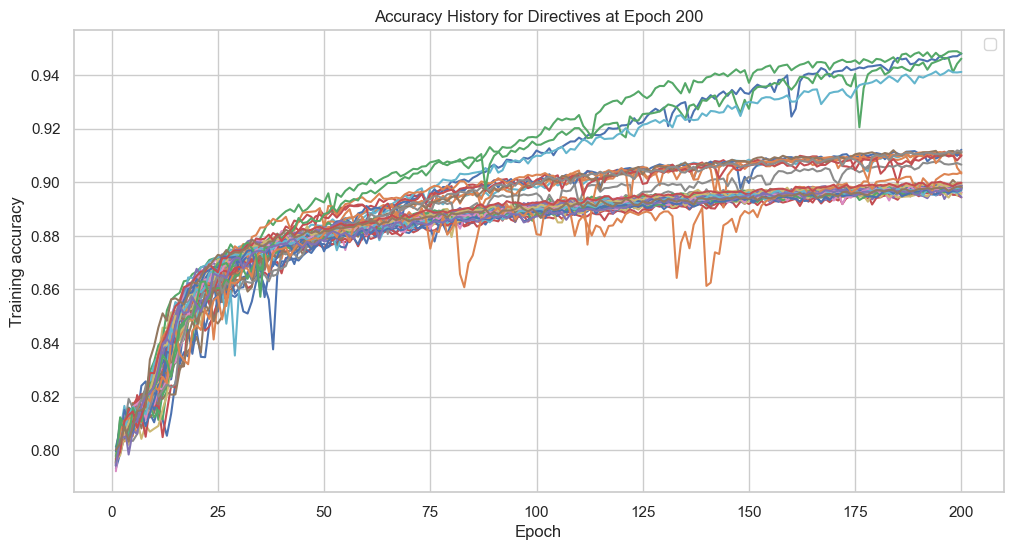

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


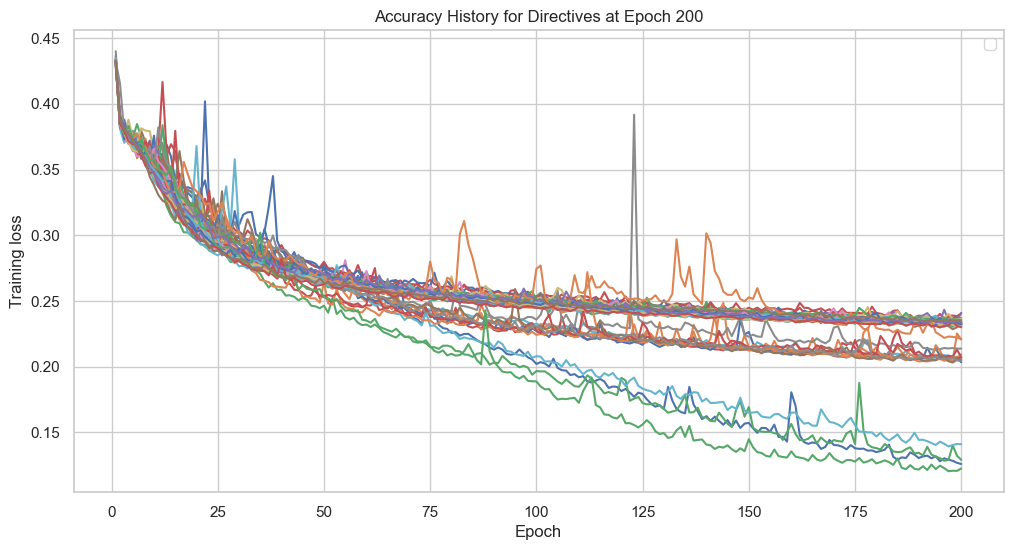

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


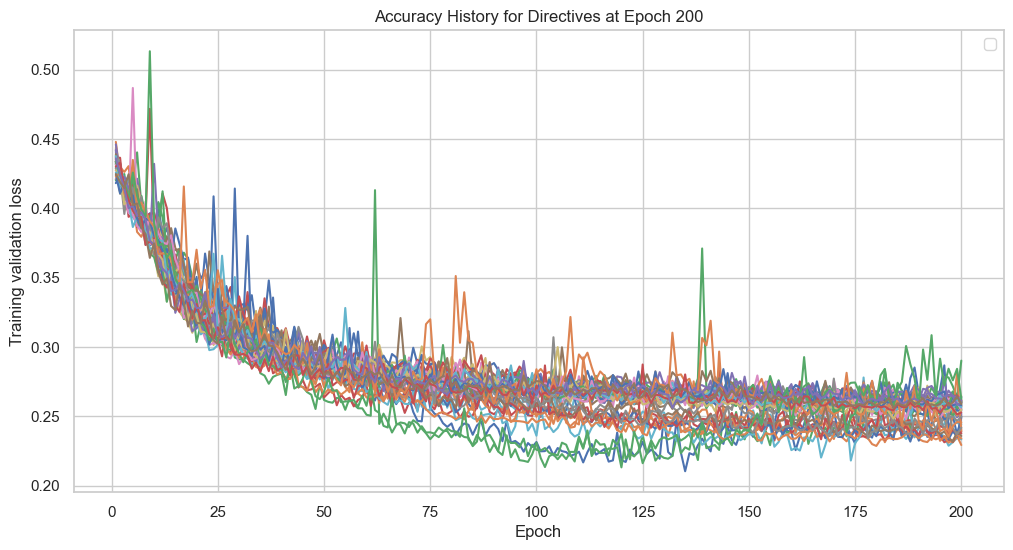

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


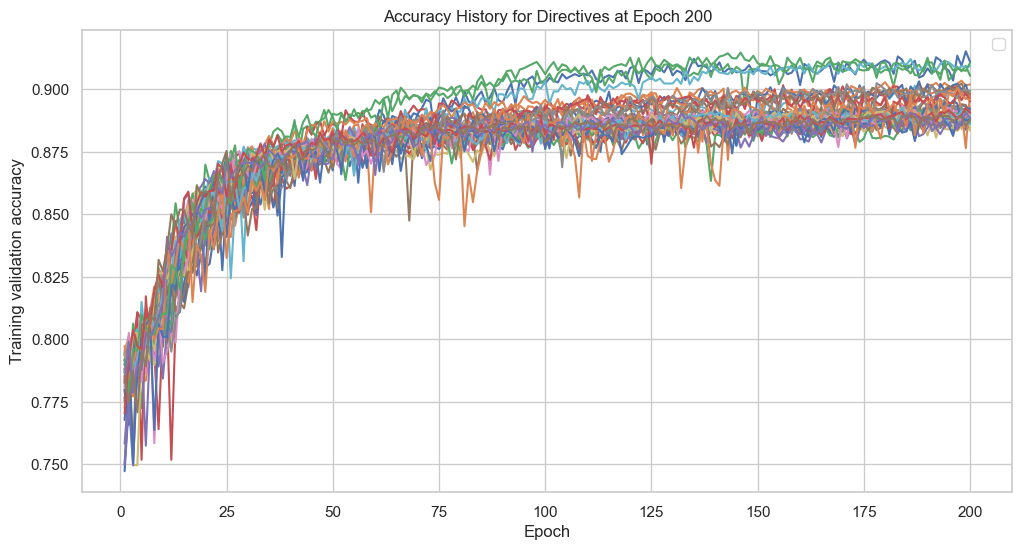

In [21]:
for epoch in [100,200]:
    for k in ['training_accuracy',
              'training_loss', 'training_val_loss', 'training_val_accuracy']:
        plot_history(df, directives=['a100-dgx', 'v100'], epoch=epoch, value=k)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


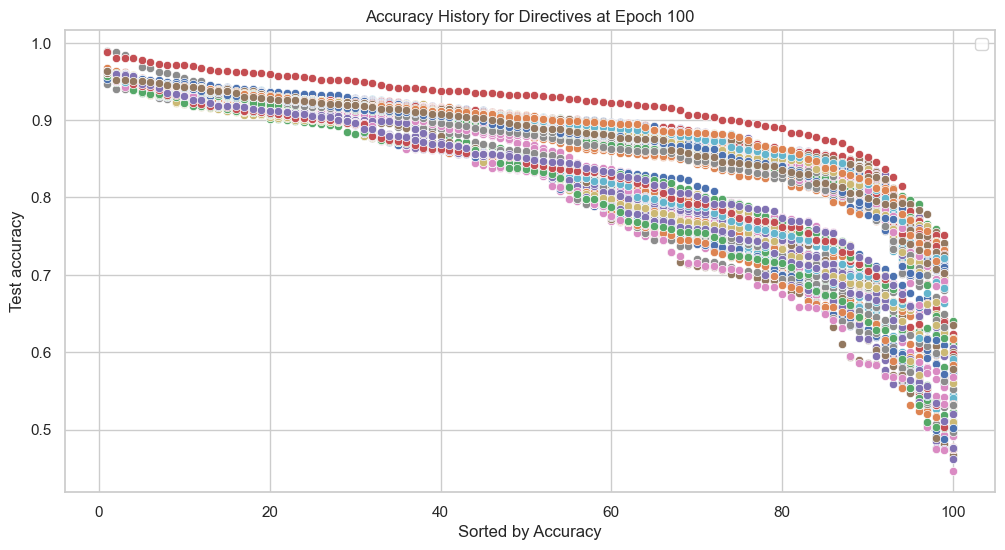

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


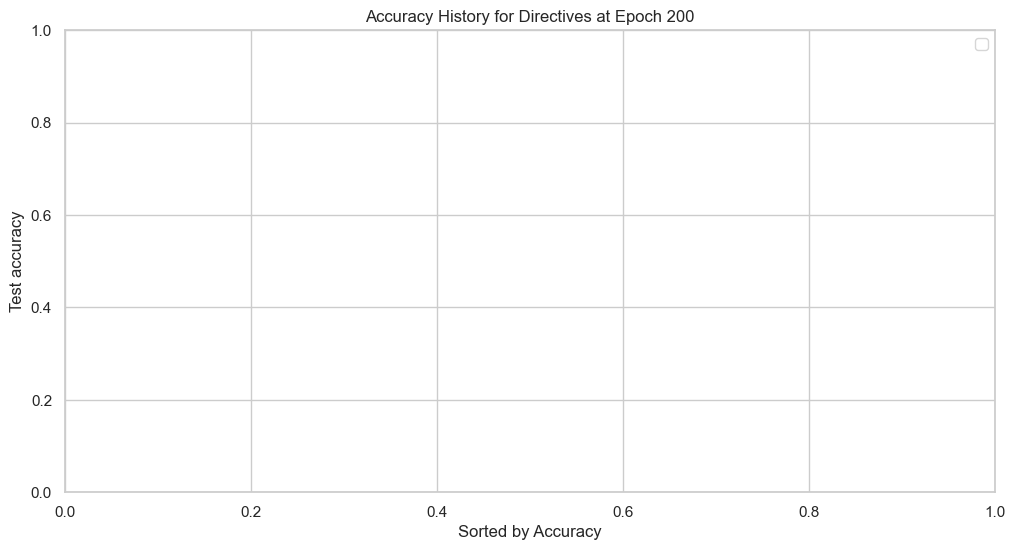

In [22]:
def plot_history(data, epoch=100, directives=["a100-dgx","v100"], value="training_accuracy"):
    df = data[data['directive'].notna()].copy()
    
    # Specify the list of directives you want to select
    selected_directives = directives # ['a100-dgx', 'v100']  # Replace with your desired directives
    selected_epoch = epoch
    
    # Create an empty list to store accuracy histories for each directive
    accuracy_histories_dict = {directive: [] for directive in selected_directives}
    
    
    
    # Iterate through the DataFrame and extract accuracy histories for selected directives
    for directive in selected_directives:
        filtered_df = df[(df['directive'] == directive) & (df[value].apply(lambda x: len(x)) >= selected_epoch)]
        
        for index, row in filtered_df.iterrows():
            accuracy_history = row[value]
            accuracy_histories_dict[directive].append(accuracy_history[:selected_epoch])
    
    # Create Seaborn line plots for each directive with a legend
    plt.figure(figsize=(12, 6))
    sns.set(style="whitegrid")
    
    for directive, accuracy_histories in accuracy_histories_dict.items():
        for idx, accuracy_history in enumerate(accuracy_histories):
            #sns.lineplot(x=range(1, selected_epoch + 1), y=accuracy_history, label=f'{directive} - Result {idx + 1}')
            sns.scatterplot(x=range(1, selected_epoch + 1), y=sorted(accuracy_history, reverse=True))
    
    plt.xlabel('Sorted by Accuracy')
    plt.ylabel(value.capitalize().replace("_", " "))
    plt.title(f'Accuracy History for Directives at Epoch {selected_epoch}')
    plt.legend()
    #plt.ylim(0.78, 0.92)
    plt.show()
for epoch in [100,200]:        
    plot_history(df, directives=['a100-dgx', 'v100'], epoch=epoch, value='test_accuracy')

In [23]:
df = df_all.copy()

def move_column_to_position(df, column_name, i):
    if i < 0 or i > len(df.columns):
        raise ValueError("Invalid position i")

    if column_name not in df.columns:
        raise ValueError(f"Column '{column_name}' not found in the DataFrame")

    columns = list(df.columns)
    columns.remove(column_name)

    if i == 0:
        columns = [column_name] + columns
    elif i == len(columns):
        columns = columns + [column_name]
    else:
        columns = columns[:i] + [column_name] + columns[i:]

    return df[columns]


df['training_val_accuracy_max'] = df['training_val_accuracy'].apply(lambda x: max(x))
df = move_column_to_position(df, 'training_val_accuracy_max', 2)

df['training_val_accuracy_last'] = df['training_val_accuracy'].apply(lambda row: row[-1])
df = move_column_to_position(df, 'training_val_accuracy_last', 2)

df['test_accuracy_sum'] = df['test_accuracy'].apply(lambda row: sum(row))
df = move_column_to_position(df, 'test_accuracy_sum', 2)

df[['training_val_accuracy_max', 'training_val_accuracy_last', 'test_accuracy_sum']] = df[['training_val_accuracy_max', 'training_val_accuracy_last', 'test_accuracy_sum']].astype(float)


In [24]:
df_sorted = df.sort_values(by='test_accuracy_sum', ascending=False)
df_sorted.insert(1, 'order', range(1, len(df) + 1))
df_sorted

name  order      total  test_accuracy_sum  \
116       v100,200      1  28989.168          91.606948   
301    a100,200.es      2   8138.858          91.533135   
391    a100,200.es      3   8258.204          89.374934   
111    a100,200.es      4  13492.980          89.351490   
95    a100-dgx,200      5  16995.992          89.324788   
..             ...    ...        ...                ...   
65   a100-dgx,1.es    393    713.734          79.346808   
191         v100,2    394    917.694          79.131916   
144      v100,1.es    395    768.871          79.020782   
360         v100,2    396    766.681          79.001883   
247      v100,2.es    397   1156.446          78.977666   

     training_val_accuracy_last  training_val_accuracy_max   training  \
116                    0.890006                   0.890255  28843.306   
301                    0.886272                   0.891669   8072.375   
391                    0.890144                   0.894709   8191.629   
111                    0.883427                   0.892286  13408.999   
95                     0.891700                   0.893626  16850.815   
..                          ...                        ...        ...   
65                     0.766749                   0.766749    568.550   
191                    0.765739                   0.796888    769.001   
144                    0.765357                   0.765357    623.570   
360                    0.774293                   0.775387    622.298   
247                    0.763275                   0.783087    950.171   

     loaddata  inference directive  repeat  epoch early_stoppage  \
116     3.168    142.301      v100      22    200          False   
301     1.567     64.697      a100      10    200           True   
391     1.510     64.866      a100      26    200           True   
111     1.539     82.232      a100      21    200           True   
95      2.701    142.255  a100-dgx      30    200          False   
..        ...        ...       ...     ...    ...            ...   
65      2.560    142.271  a100-dgx       9      1           True   
191     3.853    144.493      v100       6      2          False   
144     2.577    142.300      v100       1      1           True   
360     1.933    142.253      v100       5      2          False   
247     3.724    202.298      v100      10      2           True   

                                         test_accuracy  \
116  [0.956925, 0.9634905555555555, 0.9373077777777...   
301  [0.9604872222222223, 0.9658177777777778, 0.942...   
391  [0.935375, 0.942665, 0.9144144444444444, 0.930...   
111  [0.9325877777777778, 0.9380811111111111, 0.914...   
95   [0.930335, 0.936425, 0.9149811111111111, 0.925...   
..                                                 ...   
65   [0.8795822222222223, 0.9140866666666667, 0.659...   
191  [0.87175, 0.9089277777777778, 0.66655555555555...   
144  [0.8613572222222222, 0.9042, 0.643584444444444...   
360  [0.8768188888888889, 0.9132855555555556, 0.657...   
247  [0.8904805555555556, 0.9181922222222222, 0.658...   

                                     training_accuracy  \
116  [0.7988451719284058, 0.8043012022972107, 0.804...   
301  [0.7966084480285645, 0.8063074946403503, 0.806...   
391  [0.7938963770866394, 0.8024318218231201, 0.807...   
111  [0.7982532382011414, 0.8038661479949951, 0.804...   
95   [0.7944100499153137, 0.8044102191925049, 0.811...   
..                                                 ...   
65                                [0.7959722280502319]   
191            [0.7960338592529297, 0.805667519569397]   
144                               [0.7942774891853333]   
360           [0.7982916831970215, 0.8068831562995911]   
247           [0.7982825040817261, 0.8031982183456421]   

                                         training_loss  \
116  [0.4312030076980591, 0.3855077028274536, 0.374...   
301  [0.43297722935676575, 0.38635945320129395, 0.3...   
391  [0.4332350492477417, 0.386985063552856

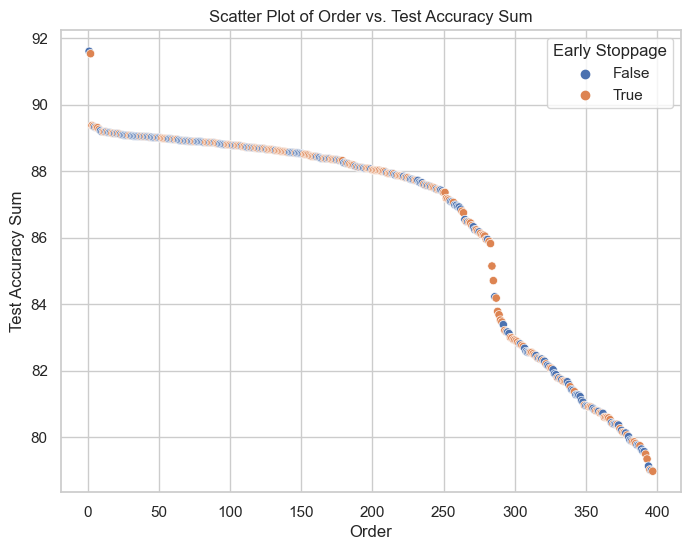

In [25]:

# Create a scatter plot
plt.figure(figsize=(8, 6))
scatter = sns.scatterplot(x='order', y='test_accuracy_sum', hue='early_stoppage', data=df_sorted)

# Set labels and title
plt.xlabel('Order')
plt.ylabel('Test Accuracy Sum')
plt.title('Scatter Plot of Order vs. Test Accuracy Sum')

legend = scatter.legend()
legend.set_title("Early Stoppage")

# Show the plot
plt.show()

In [26]:
df_sorted = df_sorted.sort_values(by='training_val_accuracy_max', ascending=False)
df_sorted

name  order      total  test_accuracy_sum  \
189      a100,200.es    176   6447.143          88.335023   
118  a100-dgx,200.es    242  16810.943          87.523382   
31      a100-dgx,200    228  17063.996          87.754645   
345         v100,200     61  28927.928          88.955229   
198      v100,200.es    179  28443.363          88.315712   
..               ...    ...        ...                ...   
166    a100-dgx,2.es    360    973.415          80.732286   
65     a100-dgx,1.es    393    713.734          79.346808   
103           v100,1    327   1075.596          82.029462   
144        v100,1.es    395    768.871          79.020782   
229        v100,1.es    353    770.819          80.913024   

     training_val_accuracy_last  training_val_accuracy_max   training  \
189                    0.913494                   0.915620   6381.601   
118                    0.910193                   0.915556  16724.849   
31                     0.911046                   0.915266  16918.073   
345                    0.910672                   0.914752  28782.107   
198                    0.914145                   0.914317  28297.379   
..                          ...                        ...        ...   
166                    0.750672                   0.768105    768.418   
65                     0.766749                   0.766749    568.550   
103                    0.766516                   0.766516    869.898   
144                    0.765357                   0.765357    623.570   
229                    0.749770                   0.749770    623.601   

     loaddata  inference directive  repeat  epoch early_stoppage  \
189     1.818     63.513      a100      27    200           True   
118     3.681     82.198  a100-dgx       1    200           True   
31      3.337    142.352  a100-dgx      22    200          False   
345     3.138    142.340      v100       8    200          False   
198     3.258    142.315      v100       6    200           True   
..        ...        ...       ...     ...    ...            ...   
166     2.533    202.232  a100-dgx       7      2           True   
65      2.560    142.271  a100-dgx       9      1           True   
103     3.051    202.304      v100       9      1          False   
144     2.577    142.300      v100       1      1           True   
229     4.521    142.460      v100       3      1           True   

                                         test_accuracy  \
189  [0.9195327777777778, 0.9241394444444444, 0.889...   
118  [0.9078772222222222, 0.91503, 0.88612777777777...   
31   [0.9048577777777778, 0.9086416666666667, 0.889...   
345  [0.9219016666666666, 0.9219905555555555, 0.887...   
198  [0.9247594444444445, 0.9290955555555556, 0.903...   
..                                                 ...   
166  [0.8404905555555555, 0.895525, 0.8082266666666...   
65   [0.8795822222222223, 0.9140866666666667, 0.659...   
103  [0.8712605555555556, 0.9241861111111112, 0.698...   
144  [0.8613572222222222, 0.9042, 0.643584444444444...   
229  [0.8404905555555555, 0.8955255555555556, 0.813...   

                                     training_accuracy  \
189  [0.795698344707489, 0.7995764017105103, 0.8049...   
118  [0.7966625690460205, 0.8051166534423828, 0.814...   
31   [0.7988681197166443, 0.8016223907470703, 0.809...   
345  [0.7959923148155212, 0.8103029727935791, 0.808...   
198  [0.7943796515464783, 0.8027954697608948, 0.806...   
..                                                 ...   
166            [0.7983068823814392, 0.801114022731781]   
65                                [0.7959722280502319]   
103                               [0.7984826564788818]   
144                               [0.7942774891853333]   
229                               [0.7941210269927979]   

                                         training_loss  \
189  [0.43303656578063965, 0.3893914520740509, 0.38...   
118  [0.4326116740703583, 0.3825846016407013, 0.373...   
31   [0.4316221177577

In [27]:
df_sorted = df_sorted.sort_values(by='training_val_accuracy_last', ascending=False)
df_sorted

name  order      total  test_accuracy_sum  \
198      v100,200.es    179  28443.363          88.315712   
189      a100,200.es    176   6447.143          88.335023   
31      a100-dgx,200    228  17063.996          87.754645   
345         v100,200     61  28927.928          88.955229   
118  a100-dgx,200.es    242  16810.943          87.523382   
..               ...    ...        ...                ...   
18        a100-dgx,2    355    659.622          80.868652   
319       a100-dgx,2    362    723.826          80.718223   
166    a100-dgx,2.es    360    973.415          80.732286   
178    a100-dgx,2.es    352    864.984          80.914548   
229        v100,1.es    353    770.819          80.913024   

     training_val_accuracy_last  training_val_accuracy_max   training  \
198                    0.914145                   0.914317  28297.379   
189                    0.913494                   0.915620   6381.601   
31                     0.911046                   0.915266  16918.073   
345                    0.910672                   0.914752  28782.107   
118                    0.910193                   0.915556  16724.849   
..                          ...                        ...        ...   
18                     0.756585                   0.776608    514.509   
319                    0.751311                   0.788440    576.504   
166                    0.750672                   0.768105    768.418   
178                    0.749842                   0.782157    659.401   
229                    0.749770                   0.749770    623.601   

     loaddata  inference directive  repeat  epoch early_stoppage  \
198     3.258    142.315      v100       6    200           True   
189     1.818     63.513      a100      27    200           True   
31      3.337    142.352  a100-dgx      22    200          False   
345     3.138    142.340      v100       8    200          False   
118     3.681     82.198  a100-dgx       1    200           True   
..        ...        ...       ...     ...    ...            ...   
18      2.524    142.282  a100-dgx       7      2          False   
319     2.509    144.509  a100-dgx       6      2          False   
166     2.533    202.232  a100-dgx       7      2           True   
178     2.809    202.572  a100-dgx       9      2           True   
229     4.521    142.460      v100       3      1           True   

                                         test_accuracy  \
198  [0.9247594444444445, 0.9290955555555556, 0.903...   
189  [0.9195327777777778, 0.9241394444444444, 0.889...   
31   [0.9048577777777778, 0.9086416666666667, 0.889...   
345  [0.9219016666666666, 0.9219905555555555, 0.887...   
118  [0.9078772222222222, 0.91503, 0.88612777777777...   
..                                                 ...   
18   [0.8404905555555555, 0.8955255555555556, 0.813...   
319  [0.8404905555555555, 0.8955255555555556, 0.813...   
166  [0.8404905555555555, 0.895525, 0.8082266666666...   
178  [0.8404905555555555, 0.8955255555555556, 0.813...   
229  [0.8404905555555555, 0.8955255555555556, 0.813...   

                                     training_accuracy  \
198  [0.7943796515464783, 0.8027954697608948, 0.806...   
189  [0.795698344707489, 0.7995764017105103, 0.8049...   
31   [0.7988681197166443, 0.8016223907470703, 0.809...   
345  [0.7959923148155212, 0.8103029727935791, 0.808...   
118  [0.7966625690460205, 0.8051166534423828, 0.814...   
..                                                 ...   
18            [0.7986000776290894, 0.8038641214370728]   
319           [0.7946540713310242, 0.8022511005401611]   
166            [0.7983068823814392, 0.801114022731781]   
178           [0.7960818409919739, 0.8035716414451599]   
229                               [0.7941210269927979]   

                                         training_loss  \
198  [0.43056702613830566, 0.396808385848999, 0.376...   
189  [0.43303656578063965, 0.3893914520740509, 0.38...   
31   [0.4316221177577

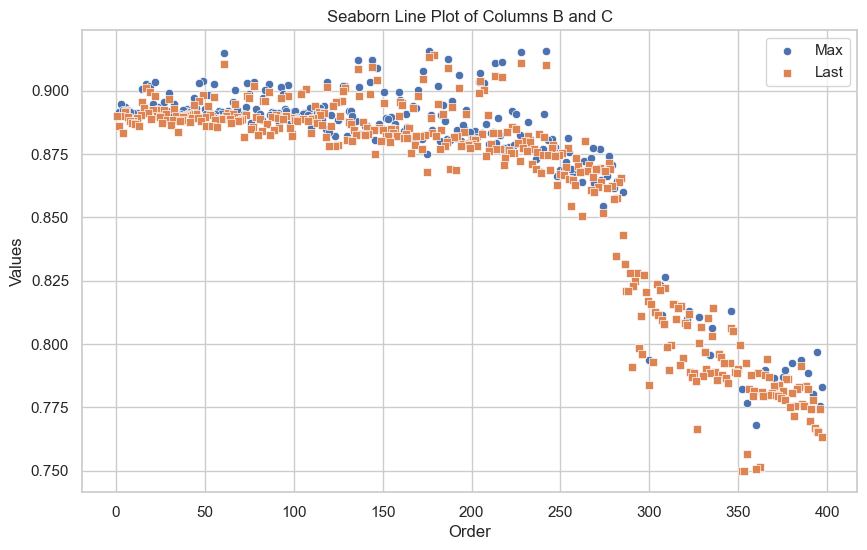

In [28]:

# Create the plot using Seaborn
plt.figure(figsize=(10, 6))  # Set the figure size
sns.scatterplot(x='order', y='training_val_accuracy_max', data=df_sorted, label='Max', marker='o')
sns.scatterplot(x='order', y='training_val_accuracy_last', data=df_sorted, label='Last', marker='s')

# Add labels and title
plt.xlabel('Order')
plt.ylabel('Values')
plt.title('Seaborn Line Plot of Columns B and C')

# Add a legend
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

In [29]:
count_series = df['early_stoppage'].value_counts()

# Convert the result to a DataFrame
count_df = count_series.reset_index()

# Rename the columns for clarity
count_df.columns = ['early_stoppage', 'count']
print(count_df)

print ("only for 200")
# Filter the DataFrame to include only rows where 'epoch' is 200
filtered_df = df[df['epoch'] == 200]

# Count the occurrences of each unique value in the 'early_stoppage' column for the filtered DataFrame
count_series = filtered_df['early_stoppage'].value_counts()

# Convert the result to a DataFrame
count_df = count_series.reset_index()

# Rename the columns for clarity
count_df.columns = ['early_stoppage', 'count']

# Print the count DataFrame
print(count_df)

  early_stoppage  count
0           True    220
1          False    177
only for 200
  early_stoppage  count
0           True     80
1          False     66


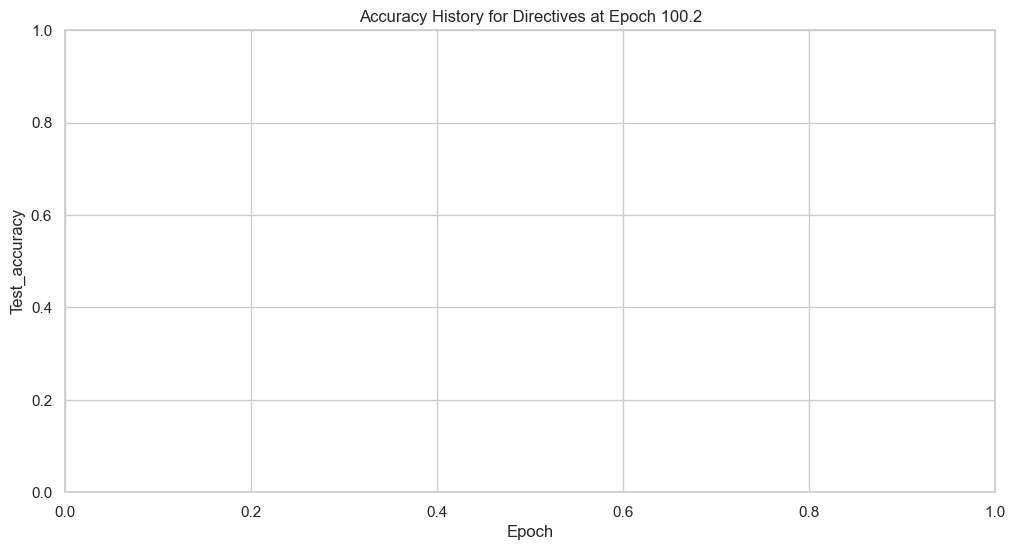

In [30]:


# does not work

def plot_history(data, epoch=100, directives=["a100-dgx", "v100"], value="training_accuracy"):
    df = data[data['directive'].notna()].copy()

    # Specify the list of directives you want to select
    selected_directives = directives
    selected_epoch = epoch

    # Create an empty list to store accuracy histories for each directive
    accuracy_histories_dict = {directive: [] for directive in selected_directives}

    # Iterate through the DataFrame and extract accuracy histories for selected directives
    for directive in selected_directives:
        filtered_df = df[(df['directive'] == directive) & (df[value].apply(lambda x: len(x)) >= selected_epoch)]

        for index, row in filtered_df.iterrows():
            accuracy_history = row[value]
            accuracy_histories_dict[directive].append(accuracy_history[:selected_epoch])

    # Create a list to store the final accuracy values and corresponding directives
    final_accuracy_values = []
    final_directives = []

    # Sort the data by the y-values (accuracy) in descending order
    for directive, accuracy_histories in accuracy_histories_dict.items():
        for idx, accuracy_history in enumerate(accuracy_histories):
            final_accuracy = accuracy_history[-1]  # Get the accuracy at the final epoch
            final_accuracy_values.append(final_accuracy)
            final_directives.append(f'{directive} - Result {idx + 1}')

    # Sort the data by accuracy in descending order
    sorted_data = sorted(zip(final_accuracy_values, final_directives), reverse=True)

    # Extract the sorted directives and accuracy values
    sorted_directives = [directive for _, directive in sorted_data]
    sorted_accuracy_values = [accuracy for accuracy, _ in sorted_data]

    # Create Seaborn line plots for each directive with a legend
    plt.figure(figsize=(12, 6))
    sns.set(style="whitegrid")

    for directive, accuracy_histories in accuracy_histories_dict.items():
        for idx, accuracy_history in enumerate(accuracy_histories):
            #sns.lineplot(x=range(1, selected_epoch + 1), y=accuracy_history, label=f'{directive} - Result {idx + 1}')
            sns.lineplot(x=range(1, selected_epoch + 1), y=accuracy_history)

    plt.xlabel('Epoch')
    plt.ylabel(value.capitalize())
    plt.title(f'Accuracy History for Directives at Epoch {selected_epoch}')
    # plt.legend(labels=sorted_directives)  # Set legend labels in the sorted order
    plt.show()

# Example usage
for epoch in [100.200]:
    plot_history(df, directives=['a100-dgx', 'v100'], epoch=epoch, value='test_accuracy')


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


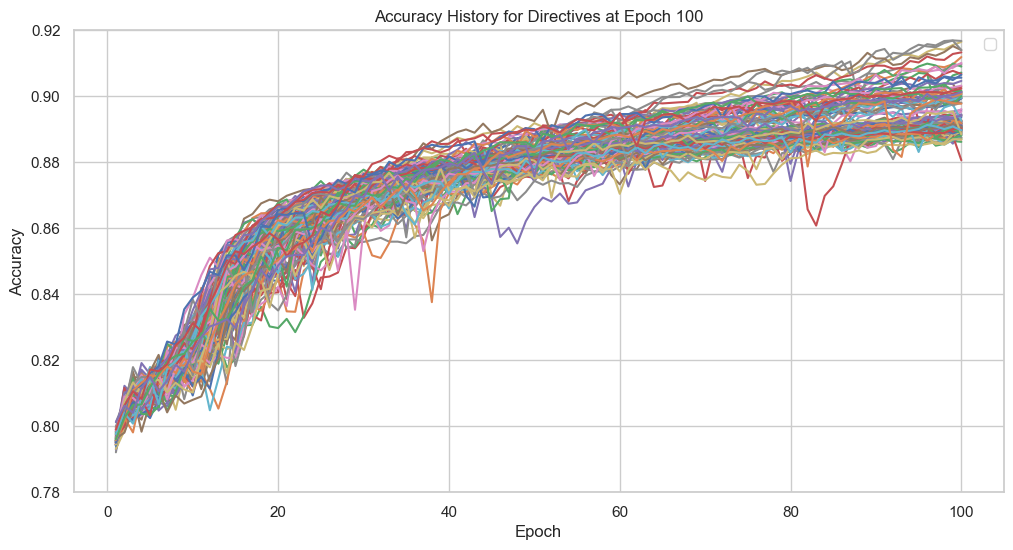

In [31]:

# Filter rows with valid directive names
df = df[df['directive'].notna()]

# Specify the list of directives you want to select
selected_directives = ['a100-dgx', 'v100']  # Replace with your desired directives
selected_epoch = 100

# Create a dictionary to store accuracy histories and best accuracies for each directive
directive_data = {}

# Iterate through the DataFrame and extract accuracy histories for selected directives
for directive in selected_directives:
    filtered_df = df[(df['directive'] == directive) & (df['training_accuracy'].apply(lambda x: len(x)) >= selected_epoch)]
    
    directive_accuracies = []
    
    for index, row in filtered_df.iterrows():
        
        accuracy_history = row["training_accuracy"]
        directive_accuracies.append(accuracy_history[:selected_epoch])
    
    # Calculate the best accuracy for this directive
    best_accuracy = max([accuracy[-1] for accuracy in directive_accuracies])
    
    directive_data[directive] = {
        'accuracies': directive_accuracies,
        'best_accuracy': best_accuracy
    }

# Sort directives by best accuracy in descending order
sorted_directives = sorted(directive_data.keys(), key=lambda x: directive_data[x]['best_accuracy'], reverse=True)

# Create Seaborn line plots for each directive with a legend
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

for directive in sorted_directives:
    for idx, accuracy_history in enumerate(directive_data[directive]['accuracies']):
        best_accuracy = directive_data[directive]['best_accuracy']
        # sns.lineplot(x=range(1, selected_epoch + 1), y=accuracy_history, label=f'{directive} - Result {idx + 1} (Best: {best_accuracy:.4f})')
        sns.lineplot(x=range(1, selected_epoch + 1), y=accuracy_history)

        
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title(f'Accuracy History for Directives at Epoch {selected_epoch}')
plt.legend()
plt.ylim(0.78, 0.92)
plt.show()


In [32]:
print(result_data[0])

{'name': 'result-thf2bn-53854471.out', 'total': 10739.745, 'training': 10590.6, 'loaddata': 4.118, 'inference': 144.679, 'directive': 'v100', 'gpu_count': '1', 'cpu_num': 1, 'mem': '64GB', 'repeat': '5', 'epoch': '70', 'seed': 1234, 'learning_rate': 0.001, 'batch_size': 32, 'train_split': 0.8, 'clip_offset': 15, 'no_cache': False, 'nodes': 1, 'gpu': 1, 'early_stoppage_patience': '25', 'early_stoppage': 'False', 'card_name': 'v100', 'result': {'value': {'name': 'cloudmask', 'training': {'samples': 970, 'accuracy': 0.8849480152130127, 'loss': 0.2601945102214813, 'val_loss': 0.2793876826763153, 'val_accuracy': 0.8799592852592468, 'history': {'accuracy': [0.7971559762954712, 0.8036167621612549, 0.8068755269050598, 0.8164012432098389, 0.8104918003082275, 0.8150579929351807, 0.809596598148346, 0.8198840618133545, 0.8231695294380188, 0.8217014074325562, 0.8314782977104187, 0.8419565558433533, 0.8467669486999512, 0.851389467716217, 0.8547239303588867, 0.8569662570953369, 0.8529560565948486, 0.

In [33]:
accuracy_list = []
loss_list = []
val_accuracy_list = []
val_loss_list = []

# Iterate through the list of dictionaries and extract the values
for entry in result_data:
    accuracy_list.extend(entry['result']['value']['inference']['accuracy'])
    loss_list.extend(entry['result']['value']['training']['history']['loss'])
    val_accuracy_list.extend(entry['result']['value']['training']['history']['val_accuracy'])
    val_loss_list.extend(entry['result']['value']['training']['history']['val_loss'])
    
print ("OOOO")
print (len(accuracy_list))
print (len(loss_list))
print (len(val_accuracy_list))
print (len(val_loss_list))

# Create a DataFrame with the extracted values
df = pd.DataFrame({
#    'Accuracy': accuracy_list,
    'Loss': loss_list,
    'Val_Accuracy': val_accuracy_list,
    'Val_Loss': val_loss_list
})
df['Index'] = range(1, len(df) + 1)
# Display the DataFrame
df

OOOO
39700
35264
35264
35264


Loss  Val_Accuracy  Val_Loss  Index
0      0.430577      0.776794  0.453891      1
1      0.386824      0.775540  0.430620      2
2      0.376532      0.801155  0.401342      3
3      0.371918      0.795250  0.420809      4
4      0.372598      0.803972  0.395189      5
...         ...           ...       ...    ...
35259  0.247166      0.879058  0.282252  35260
35260  0.430021      0.781029  0.439819  35261
35261  0.429325      0.780086  0.434814  35262
35262  0.382696      0.777929  0.423407  35263
35263  0.429758      0.771661  0.435519  35264

[35264 rows x 4 columns]

In [34]:
print(df.head)


<bound method NDFrame.head of            Loss  Val_Accuracy  Val_Loss  Index
0      0.430577      0.776794  0.453891      1
1      0.386824      0.775540  0.430620      2
2      0.376532      0.801155  0.401342      3
3      0.371918      0.795250  0.420809      4
4      0.372598      0.803972  0.395189      5
...         ...           ...       ...    ...
35259  0.247166      0.879058  0.282252  35260
35260  0.430021      0.781029  0.439819  35261
35261  0.429325      0.780086  0.434814  35262
35262  0.382696      0.777929  0.423407  35263
35263  0.429758      0.771661  0.435519  35264

[35264 rows x 4 columns]>


In [35]:
n = 10
sorted_loss_df = df.sort_values(by='Loss', ascending=True)
sorted_loss_df.head(n)


Loss  Val_Accuracy  Val_Loss  Index
31481  0.120424      0.908350  0.284423  31482
31483  0.120699      0.907398  0.284332  31484
31482  0.120848      0.907878  0.276049  31483
31476  0.121382      0.907522  0.276411  31477
31474  0.121685      0.912636  0.256596  31475
31471  0.122044      0.905737  0.300816  31472
31478  0.122106      0.911602  0.262896  31479
31473  0.122278      0.908028  0.277388  31474
31484  0.122564      0.910672  0.262750  31485
31480  0.122797      0.905795  0.272398  31481

In [36]:
n = 10
sorted_loss_df = df.sort_values(by='Val_Accuracy', ascending=False)
sorted_loss_df.head(n)

Loss  Val_Accuracy  Val_Loss  Index
17230  0.145710      0.915620  0.219223  17231
10993  0.140451      0.915556  0.214159  10994
3015   0.126850      0.915266  0.236776   3016
31430  0.137208      0.914752  0.229303  31431
10979  0.147956      0.914740  0.214026  10980
31427  0.139101      0.914459  0.229796  31428
17885  0.158728      0.914317  0.219280  17886
17888  0.157153      0.914145  0.220213  17889
17869  0.165615      0.914044  0.213253  17870
10991  0.141498      0.914016  0.213241  10992

In [37]:
n = 10
sorted_loss_df = df.sort_values(by='Val_Loss', ascending=True)
sorted_loss_df.head(n)

Loss  Val_Accuracy  Val_Loss  Index
2951   0.164498      0.912254  0.210480   2952
17863  0.165594      0.912952  0.213019  17864
10991  0.141498      0.914016  0.213241  10992
17869  0.165615      0.914044  0.213253  17870
31404  0.163865      0.912730  0.213262  31405
31386  0.182716      0.910929  0.213511  31387
25101  0.192704      0.911634  0.213893  25102
10979  0.147956      0.914740  0.214026  10980
10993  0.140451      0.915556  0.214159  10994
17862  0.170885      0.910934  0.214386  17863

In [38]:
df = pd.DataFrame({
    'Accuracy': accuracy_list,
})
df['Index'] = range(1, len(df) + 1)
# Display the DataFrame
df

Accuracy  Index
0      0.923344      1
1      0.934509      2
2      0.894077      3
3      0.910514      4
4      0.839129      5
...         ...    ...
39695  0.751298  39696
39696  0.867493  39697
39697  0.718101  39698
39698  0.826334  39699
39699  0.837769  39700

[39700 rows x 2 columns]

In [39]:
n = 10
sorted_accuracy_loss = df.sort_values(by='Accuracy', ascending=False)
sorted_accuracy_loss.head(n)


Accuracy  Index
10309  0.989144  10310
30109  0.988468  30110
10322  0.988317  10323
11609  0.987953  11610
8509   0.986433   8510
8522   0.985733   8523
10305  0.984737  10306
8557   0.982523   8558
30194  0.982375  30195
8505   0.981844   8506